In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin, BaseEstimator

# preprocessing imports
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, OneHotEncoder, PowerTransformer, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model building imports
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
train_df_original=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_df_original=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
sample_df_original=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")

# making clones of original datasets, to avoid any date loss
train_df = train_df_original.copy()
test_df = test_df_original.copy()
sample_df = sample_df_original.copy()

In [3]:
train_df

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no


In [4]:
test_df

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2010-11-20,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,NaN
9996,2009-06-03,26,admin.,single,secondary,no,317,yes,no,NaN,953,1,-1,0,NaN
9997,2010-04-20,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,NaN
9998,2010-02-17,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,NaN


# Input variables:
 1. last contact date: last contact date
 2. age (numeric)
 3. job : type of job
 4. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
 5. education (categorical: "unknown","secondary","primary","tertiary")
 6. default: has credit in default? (binary: "yes","no")
 7. balance: average yearly balance, in euros (numeric)
 8. housing: has housing loan? (binary: "yes","no")
 9. loan: has personal loan? (binary: "yes","no")
 10. contact: contact communication type (categorical: "unknown","telephone","cellular")
 11. duration: last contact duration, in seconds (numeric)
 12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
 14. previous: number of contacts performed before this campaign and for this client (numeric)
 15. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

# Output variable (desired target):
 16. target: has the client subscribed a term deposit? (binary: "yes","no")

# Understanding training set

## Samples

In [5]:
train_df.sample(10)

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
15525,2008-06-16,30,management,single,tertiary,no,775,yes,no,NaN,124,2,-1,0,NaN,no
24544,2010-04-17,32,blue-collar,married,secondary,no,225,yes,no,cellular,574,1,150,1,failure,yes
32294,2008-12-22,87,housemaid,married,secondary,yes,77,yes,no,cellular,4644,12,737,248,other,yes
23560,2009-02-10,35,technician,single,secondary,no,1693,yes,no,cellular,515,1,-1,0,NaN,yes
30678,2010-11-20,41,blue-collar,married,primary,no,875,yes,no,cellular,197,1,-1,0,NaN,no
14503,2010-11-18,38,entrepreneur,married,tertiary,no,0,yes,no,cellular,185,3,-1,0,NaN,no
9230,2008-05-30,51,entrepreneur,married,secondary,no,0,no,no,NaN,510,3,-1,0,NaN,no
2665,2008-07-17,31,management,divorced,tertiary,no,294,yes,no,cellular,536,5,-1,0,NaN,yes
17492,2010-11-20,51,blue-collar,married,secondary,no,8180,yes,no,cellular,86,1,-1,0,NaN,no
4228,2009-10-25,43,entrepreneur,married,primary,yes,74224,no,no,telephone,4661,19,295,82,other,no


In [6]:
train_df.shape

(39211, 16)

**Number of observations**  : 39211

**Number of variables**     : 16

In [7]:
train_df.size

627376

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

Here **last contact date** is date time but stored as a string.

In [9]:
# Converting 'last contact date' to datetime datatype
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])

In [10]:
train_df['last contact date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 39211 entries, 0 to 39210
Series name: last contact date
Non-Null Count  Dtype         
--------------  -----         
39211 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 306.5 KB


In [11]:
train_df.describe()

,last contact date,age,balance,duration,campaign,pdays,previous
count,39211,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,2009-06-22 21:10:55.254902784,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
min,2008-01-01 00:00:00,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,2008-08-11 00:00:00,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,2009-06-05 00:00:00,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,2010-05-08 00:00:00,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,2010-12-30 00:00:00,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000
std,NaN,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259


In [12]:
# Checking Deblicate Rows
train_df.duplicated().sum()

0

## Column types

Dividing columsn into 4 types:
1. Numerical Columns
2. Datetime Columns
3. Boolean Categorical Columns
4. Multiclass Categorical Columns


In [13]:
# Separate numerical columns
numerical_columns = train_df.select_dtypes(include=['number'])

# Seperate Datetime Columns
datetime_columns = train_df.select_dtypes(include=['datetime'])

# Separate Boolean categorical columns (eg: "yes,no", "True,False" etc)
boolean_categorical_columns = train_df[['default', 'housing', 'loan', 'target']]

# Separate categorical columns with more than two categories
multiclass_categorical_columns = train_df[['job', 'marital', 'education', 'contact', 'poutcome']]



# Display the result
print("Numerical Columns", numerical_columns.columns , sep = " : ")
print("Datetime Columns", datetime_columns.columns , sep = " : ")
print("Boolean Categorical Columns", boolean_categorical_columns.columns , sep = " : ")
print("Multiclass Categorical Columns", multiclass_categorical_columns.columns , sep = " : ")

Numerical Columns : Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')
Datetime Columns : Index(['last contact date'], dtype='object')
Boolean Categorical Columns : Index(['default', 'housing', 'loan', 'target'], dtype='object')
Multiclass Categorical Columns : Index(['job', 'marital', 'education', 'contact', 'poutcome'], dtype='object')


### Numerical Columns

In [14]:
numerical_columns.sample(5)

,age,balance,duration,campaign,pdays,previous
35814,29,769,67,3,-1,0
25121,38,395,83,1,367,2
23681,45,4696,99,1,-1,0
36271,25,1857,187,1,91,12
37052,19,24540,4598,57,813,262


In [15]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       39211 non-null  int64
 1   balance   39211 non-null  int64
 2   duration  39211 non-null  int64
 3   campaign  39211 non-null  int64
 4   pdays     39211 non-null  int64
 5   previous  39211 non-null  int64
dtypes: int64(6)
memory usage: 1.8 MB


In [16]:
numerical_columns.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


### Datetime Columns

In [17]:
datetime_columns.sample(5)

,last contact date
19167,2008-07-28
14256,2009-07-15
7074,2009-07-24
13531,2008-12-30
29735,2009-06-02


In [18]:
datetime_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   last contact date  39211 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 306.5 KB


In [19]:
datetime_columns.describe()

,last contact date
count,39211
mean,2009-06-22 21:10:55.254902784
min,2008-01-01 00:00:00
25%,2008-08-11 00:00:00
50%,2009-06-05 00:00:00
75%,2010-05-08 00:00:00
max,2010-12-30 00:00:00


### Boolean Categorical Columns

In [20]:
boolean_categorical_columns.sample(5)

,default,housing,loan,target
9041,no,no,no,no
23836,no,no,no,no
34635,no,no,no,no
36186,no,no,no,no
6586,no,no,no,no


In [21]:
boolean_categorical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   default  39211 non-null  object
 1   housing  39211 non-null  object
 2   loan     39211 non-null  object
 3   target   39211 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [22]:
boolean_categorical_columns.describe()

,default,housing,loan,target
count,39211,39211,39211,39211
unique,2,2,2,2
top,no,yes,no,no
freq,36954,21657,31820,33384


### Multiclass Categorical Columns

In [23]:
multiclass_categorical_columns.sample(5)

,job,marital,education,contact,poutcome
29599,blue-collar,married,secondary,NaN,NaN
36110,management,single,tertiary,cellular,failure
5965,blue-collar,single,secondary,cellular,other
10098,services,married,secondary,cellular,NaN
25703,unemployed,married,primary,NaN,NaN


In [24]:
multiclass_categorical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job        38982 non-null  object
 1   marital    39211 non-null  object
 2   education  37744 non-null  object
 3   contact    28875 non-null  object
 4   poutcome   9760 non-null   object
dtypes: object(5)
memory usage: 1.5+ MB


In [25]:
multiclass_categorical_columns.describe()

,job,marital,education,contact,poutcome
count,38982,39211,37744,28875,9760
unique,11,3,3,2,3
top,blue-collar,married,secondary,cellular,failure
freq,7776,22691,19584,25030,4949


## Missing values

In [26]:
# Missing values (NaN)
train_df.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [27]:
# Total Null Values
train_df.isna().sum().sum()

41483

In [28]:
# Missing data percentage
(train_df.isna().sum().sum())/(train_df.size)*100

6.612143276121496

In [29]:
# percentage of null values per column
null_percentage = train_df.isnull().mean() * 100

print(null_percentage)

last contact date     0.000000
age                   0.000000
job                   0.584020
marital               0.000000
education             3.741297
default               0.000000
balance               0.000000
housing               0.000000
loan                  0.000000
contact              26.359950
duration              0.000000
campaign              0.000000
pdays                 0.000000
previous              0.000000
poutcome             75.109026
target                0.000000
dtype: float64


**Missing Columns**
1. job
2. education
3. contact
4. poutcome

In [30]:
missing_columns = train_df[['job', 'education', 'contact', 'poutcome']]

### visualization of nullity by column

A simple visualization of nullity by column.

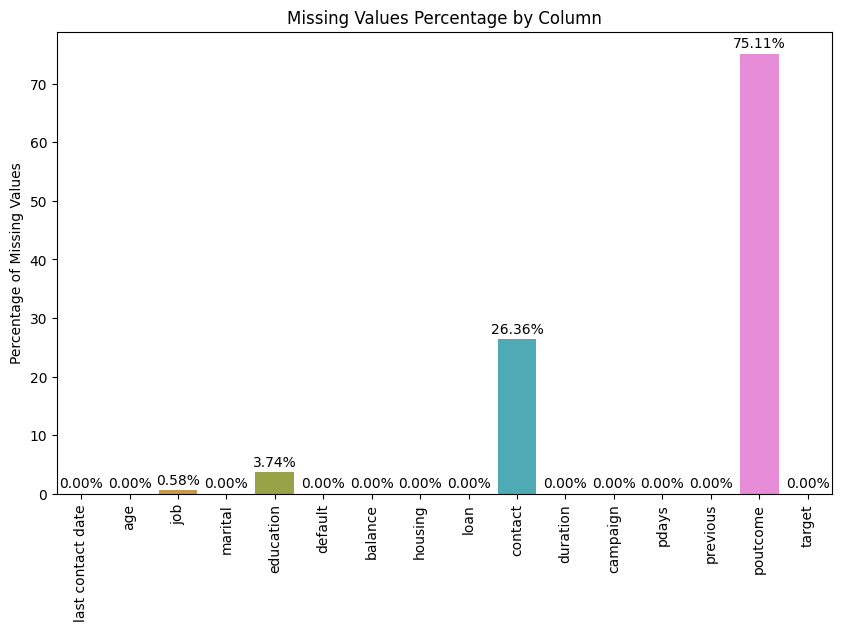

In [31]:
# Calculate the percentage of missing values per column
missing_values = train_df.isnull().mean() * 100

# Plot the nullity bar plot with percentages
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Percentage by Column')

# Display percentage annotations on top of bars
for index, value in enumerate(missing_values):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center')

plt.show()


### Nullity matrix

Nullity matrix is a data-dense display which helps to quickly visually pick out patterns in data completion.

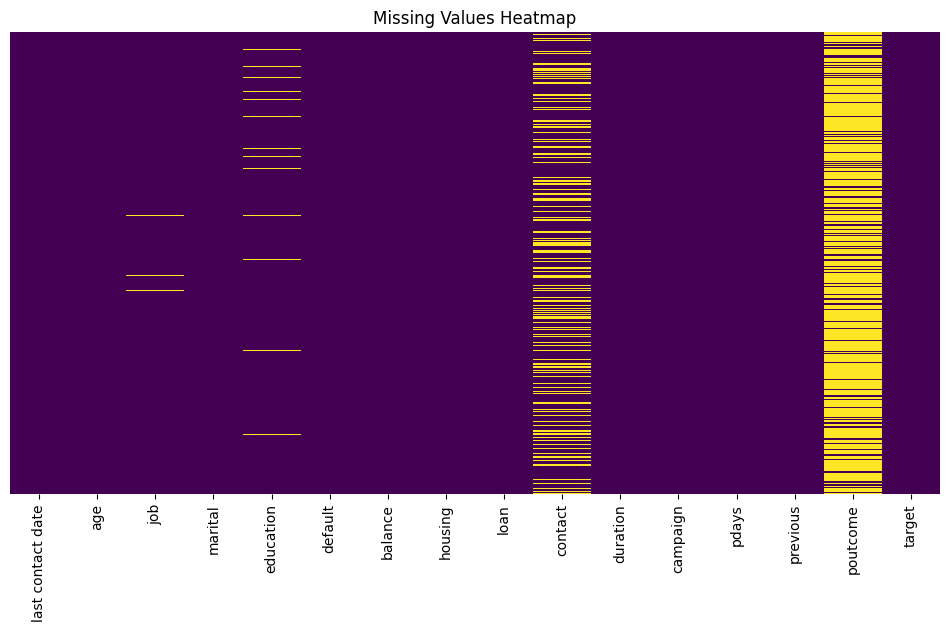

In [32]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

### Nullity Correlation Heatmap

The correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

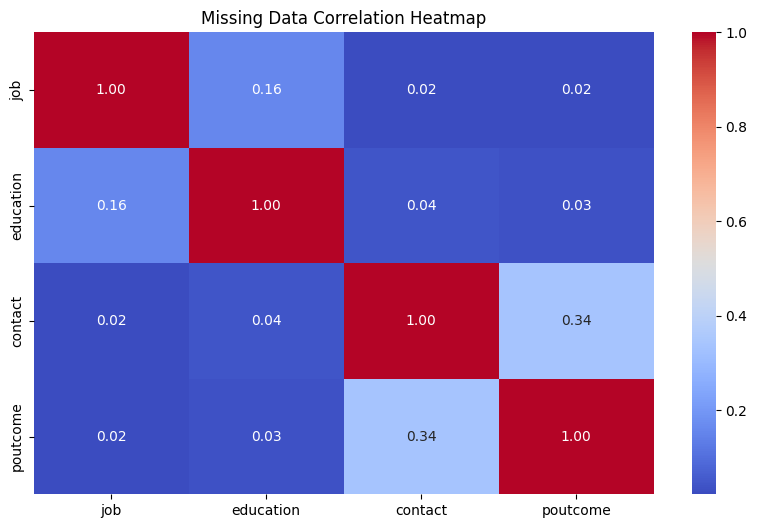

In [33]:
corr_matrix = missing_columns.isnull().corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Missing Data Correlation Heatmap")
plt.show()

## Insights
1. Number of observations : 39211
2. Number of variables : 16
3. Missing cells : 41483
4. Missing cells (%) : 6.6%
5. Four Columns have missing values : **job, education, contact, poutcome**
6. **contact and poutcome** column has very high number of missing values 26.35% and 75.10% respectively
7. Small nullity co-releation btween these columns : **(contact, poutcome), (job, education)**
8. No Dublicate Samples
9. DateTime Column (1): '**last contact date**'.
10. Numarical columns (6): **'age', 'balance', 'duration', 'campaign', 'pdays', 'previous'**
11. Boolean Categorical Columns (4) : **'default', 'housing', 'loan', 'target'**
12. Multiclass Categorical Columns (5) : **'job', 'marital', 'education', 'contact', 'poutcome'**


# EDA - Univariate Analysis

## DateTime Column

In [34]:
datetime_columns.sample(5)

,last contact date
8905,2010-07-25
11674,2008-11-11
17406,2010-08-08
23003,2009-04-17
17765,2010-04-15


#### 1. **last contact date** Column

In [35]:
datetime_columns['last contact date'].value_counts().reset_index()

,last contact date,count
0,2009-05-15,313
1,2008-05-15,301
2,2009-05-14,292
3,2010-05-15,292
4,2009-05-13,279
...,...,...
1008,2009-08-09,1
1009,2008-08-30,1
1010,2009-10-31,1
1011,2009-07-26,1


In [36]:
print("---------")
print("Min date : ", datetime_columns['last contact date'].min())
print("---------")
print("Max date : ", datetime_columns['last contact date'].max())
print("---------")
print("Mean date : ", datetime_columns['last contact date'].mean())
print("---------")
print("Median date : ", datetime_columns['last contact date'].median())
print("---------")
print("Mode date : ", datetime_columns['last contact date'].mode()[0])
print("---------")
print("Std date : ", datetime_columns['last contact date'].std())
print("---------")

---------
Min date :  2008-01-01 00:00:00
---------
Max date :  2010-12-30 00:00:00
---------
Mean date :  2009-06-22 21:10:55.254902784
---------
Median date :  2009-06-05 00:00:00
---------
Mode date :  2009-05-15 00:00:00
---------
Std date :  309 days 05:31:16.973141312
---------


In [37]:
train_df[datetime_columns['last contact date'] == datetime_columns['last contact date'].min()]

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
4251,2008-01-01,25,housemaid,divorced,tertiary,yes,70239,yes,no,cellular,673,14,117,188,success,no
10597,2008-01-01,35,unemployed,married,secondary,yes,67347,no,yes,cellular,1400,24,409,194,success,yes
13993,2008-01-01,71,student,single,secondary,yes,98914,yes,yes,telephone,4777,7,133,237,other,yes
15437,2008-01-01,43,student,married,secondary,no,73150,yes,yes,telephone,4383,34,726,170,success,yes
17318,2008-01-01,66,self-employed,married,secondary,yes,97558,no,no,telephone,2054,39,827,129,success,yes
20750,2008-01-01,64,unemployed,married,secondary,no,100667,no,yes,cellular,3881,24,299,209,success,yes
22407,2008-01-01,67,self-employed,single,tertiary,no,30571,no,no,cellular,1913,15,43,239,other,yes


In [38]:
train_df[datetime_columns['last contact date'] == datetime_columns['last contact date'].min()].shape

(7, 16)

In [39]:
train_df[datetime_columns['last contact date'] == datetime_columns['last contact date'].max()]

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
5058,2010-12-30,62,unemployed,married,primary,yes,24964,no,no,telephone,2580,57,712,93,failure,no
6416,2010-12-30,94,entrepreneur,divorced,secondary,no,38783,no,yes,cellular,1597,19,625,201,success,yes
9040,2010-12-30,30,housemaid,single,tertiary,no,3185,yes,no,cellular,158,3,-1,0,NaN,no
9979,2010-12-30,88,student,single,secondary,no,12536,no,yes,cellular,2012,47,319,261,success,yes
10918,2010-12-30,30,management,single,tertiary,no,2907,yes,no,cellular,146,2,218,1,failure,no
11721,2010-12-30,66,housemaid,single,primary,yes,94130,yes,yes,telephone,2416,37,795,132,success,yes
15684,2010-12-30,69,housemaid,divorced,primary,yes,73117,yes,yes,cellular,3424,53,810,109,other,no
22460,2010-12-30,61,unemployed,single,secondary,no,8770,no,yes,cellular,3163,44,652,229,success,yes
25314,2010-12-30,25,self-employed,married,secondary,yes,67295,no,no,telephone,1092,9,818,113,success,yes
27270,2010-12-30,25,self-employed,married,primary,yes,47699,yes,no,telephone,4352,58,307,132,success,yes


In [40]:
train_df[datetime_columns['last contact date'] == datetime_columns['last contact date'].max()].shape

(14, 16)

In [41]:
print("---------")
# IQR Q1
Q1 = datetime_columns['last contact date'].quantile(0.25)
print("25th percentile : ", Q1)
print("---------")
# IQR Q2
Q3 = datetime_columns['last contact date'].quantile(0.75)
print("75th percentile : ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR : ", iqr)
print("---------")

---------
25th percentile :  2008-08-11 00:00:00
---------
75th percentile :  2010-05-08 00:00:00
---------
IQR :  635 days 00:00:00
---------


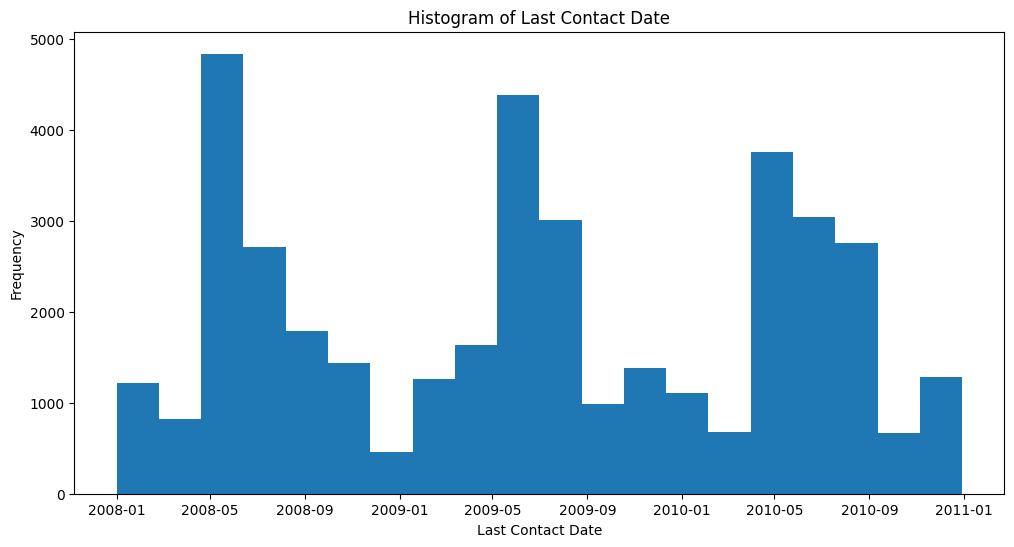

In [42]:
# Set figure size
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Plot histogram
plt.hist(datetime_columns['last contact date'], bins=20)
plt.title("Histogram of Last Contact Date")
plt.xlabel("Last Contact Date")
plt.ylabel("Frequency")
plt.show()


#### Conclusion
1. multimodal graph

## Boolean Categorical Columns

In [43]:
boolean_categorical_columns.sample(5)

,default,housing,loan,target
8712,no,no,no,yes
6055,no,no,no,no
31400,no,no,yes,no
9624,no,no,no,no
14813,no,yes,no,no


### 1. **default** Column

In [44]:
boolean_categorical_columns['default'].value_counts().reset_index()

,default,count
0,no,36954
1,yes,2257


<Axes: xlabel='default'>

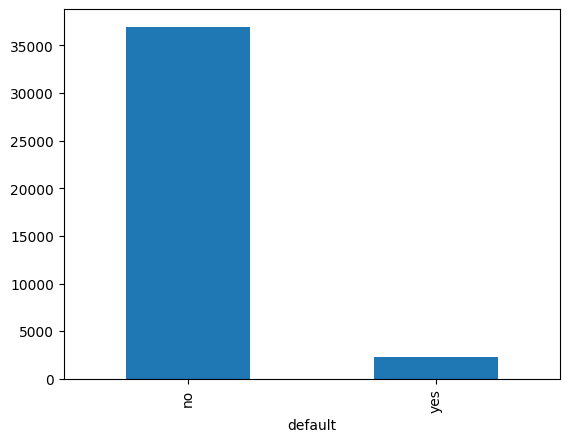

In [45]:
boolean_categorical_columns['default'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

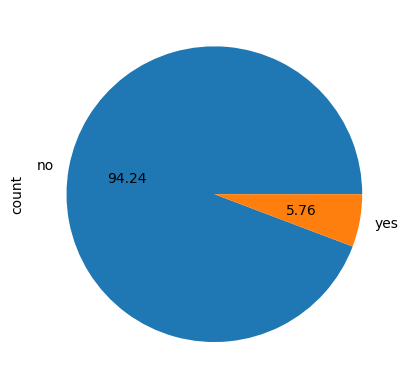

In [46]:
boolean_categorical_columns['default'].value_counts().plot(kind='pie', autopct='%.2f')

##### Conclusion¶¶
1. more than 90% of dataset doesn't have default credit

### 2. **housing** Column


In [47]:
boolean_categorical_columns['housing'].value_counts().reset_index()

,housing,count
0,yes,21657
1,no,17554


<Axes: xlabel='housing'>

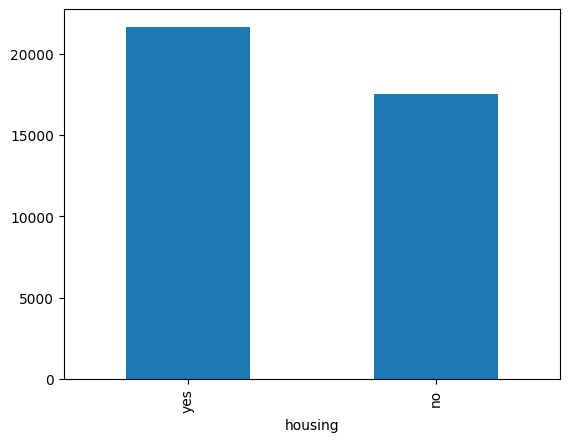

In [48]:
boolean_categorical_columns['housing'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

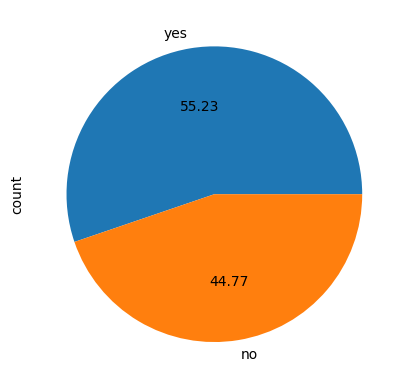

In [49]:
boolean_categorical_columns['housing'].value_counts().plot(kind='pie', autopct='%.2f')

#### Conclusion1. 
dataset is almost equaly divided between people having and not having house loans

### 3. **loan** Column

In [50]:
train_df['loan'].value_counts().reset_index()

,loan,count
0,no,31820
1,yes,7391


<Axes: xlabel='loan'>

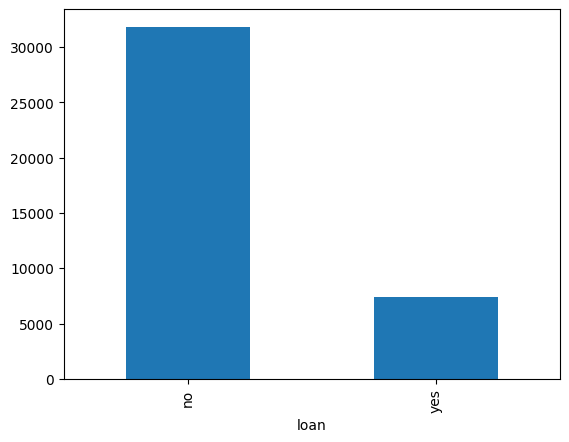

In [51]:
train_df['loan'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

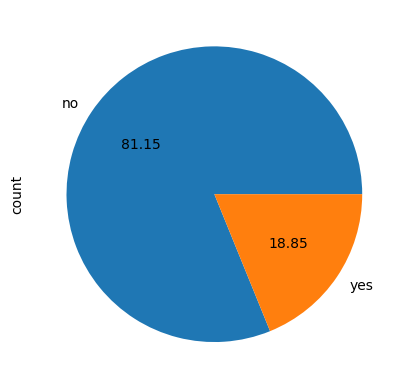

In [52]:
train_df['loan'].value_counts().plot(kind='pie', autopct='%.2f')

#### Conclusion
1. more than 80% of the sample doesn't have personal loans

### 4. **target** Column

In [53]:
boolean_categorical_columns['target'].value_counts().reset_index()

,target,count
0,no,33384
1,yes,5827


<Axes: xlabel='target'>

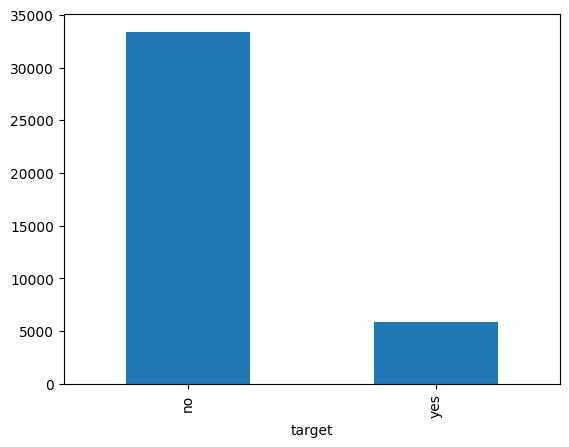

In [54]:
boolean_categorical_columns['target'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

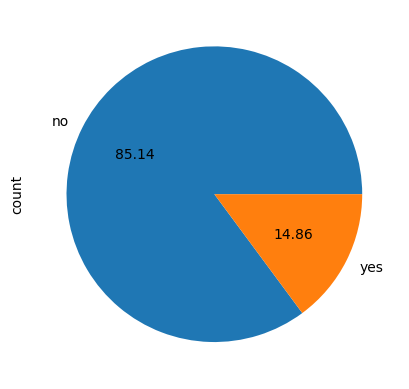

In [55]:
boolean_categorical_columns['target'].value_counts().plot(kind='pie', autopct='%.2f')

#### Conclusion
1. majority (more than 80%) of the campaigns were unsuccessful

## Multiclass Categorical Columns

In [56]:
multiclass_categorical_columns.sample(5)

,job,marital,education,contact,poutcome
24927,technician,divorced,tertiary,NaN,NaN
19344,self-employed,divorced,tertiary,telephone,other
36491,unemployed,single,secondary,NaN,NaN
21272,services,single,secondary,NaN,NaN
33278,management,single,tertiary,cellular,NaN


### 1. **job** column

In [57]:
multiclass_categorical_columns['job'].value_counts()

job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64

<Axes: xlabel='job'>

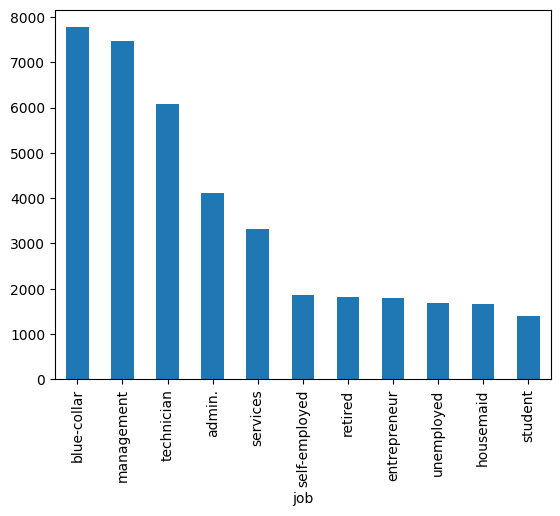

In [58]:
multiclass_categorical_columns['job'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

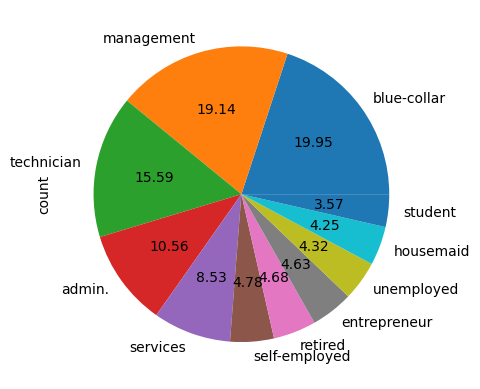

In [59]:
multiclass_categorical_columns['job'].value_counts().plot(kind='pie', autopct='%.2f')

##### Conclusion

1. blue-collar, management and technician collectively covers more than 50% of dataset

### 2. **marital** Column

In [60]:
multiclass_categorical_columns['marital'].value_counts()

marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64

<Axes: xlabel='marital'>

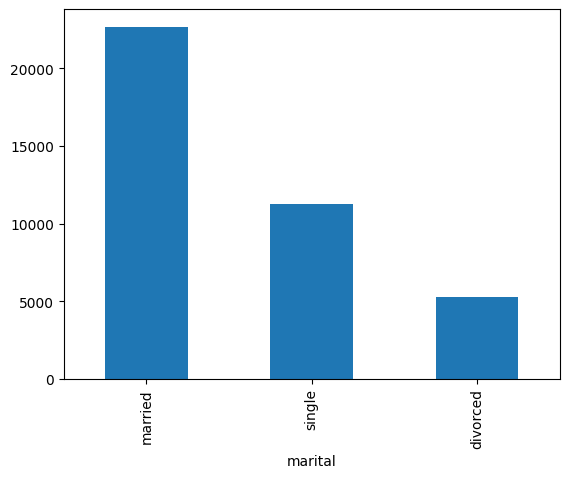

In [61]:
multiclass_categorical_columns['marital'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

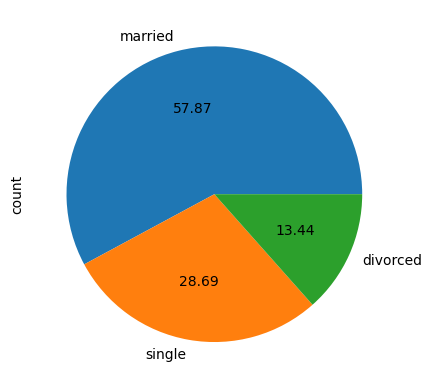

In [62]:
multiclass_categorical_columns['marital'].value_counts().plot(kind='pie', autopct='%.2f')

##### Conclusion¶
1. more than 50% of dataset is married

### 3. **education** Column

In [63]:
multiclass_categorical_columns['education'].value_counts()

education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

<Axes: xlabel='education'>

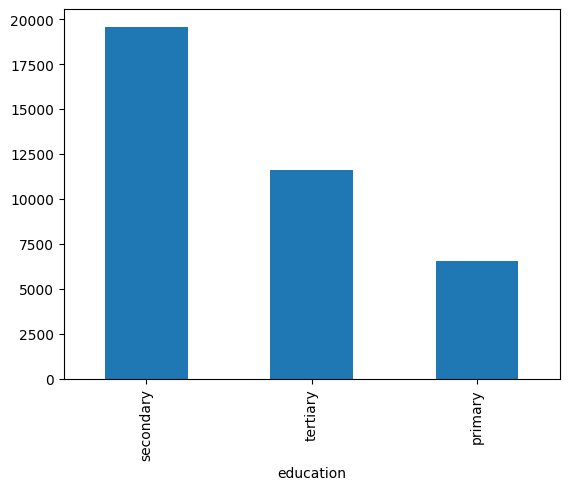

In [64]:
multiclass_categorical_columns['education'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

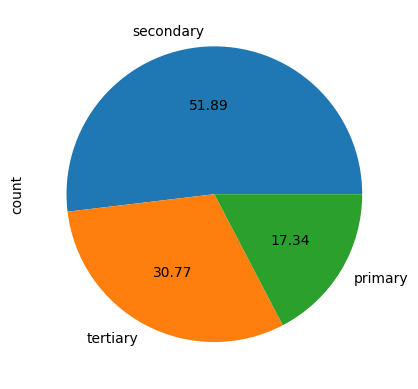

In [65]:
multiclass_categorical_columns['education'].value_counts().plot(kind='pie', autopct='%.2f')

##### Conclusion¶
1. more than 50% of dataset has secondary education

### 4. **contact** Column

In [66]:
multiclass_categorical_columns['contact'].value_counts()

contact
cellular     25030
telephone     3845
Name: count, dtype: int64

<Axes: xlabel='contact'>

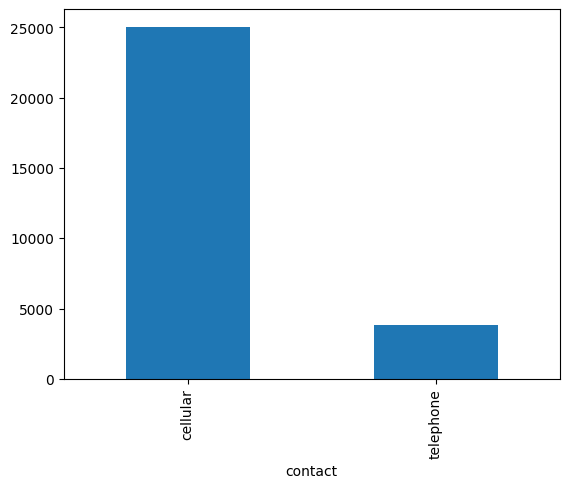

In [67]:
multiclass_categorical_columns['contact'].value_counts().plot(kind='bar')

<Axes: ylabel='count'>

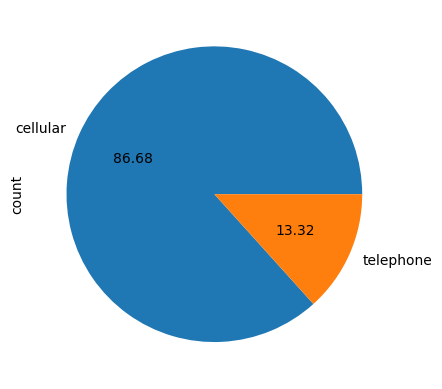

In [68]:
multiclass_categorical_columns['contact'].value_counts().plot(kind='pie', autopct='%.2f')

##### Conclusion¶¶¶¶
1. more than 80% of the sample have cellular communication connection.
2. could be missleading since almost 25% of the sample is missing.

## Insights

## Numarical Columns

In [69]:
numerical_columns.sample(5)

,age,balance,duration,campaign,pdays,previous
19246,31,851,158,1,-1,0
26632,43,506,398,1,-1,0
22512,60,7440,92,3,-1,0
34551,51,0,297,8,-1,0
6993,31,183,495,1,-1,0


### 1. **age** Column

In [70]:
print("---------")
print("Min age : ", numerical_columns['age'].min())
print("---------")
print("Max age : ", numerical_columns['age'].max())
print("---------")
print("Mean age : ", numerical_columns['age'].mean())
print("---------")
print("Median age : ", numerical_columns['age'].median())
print("---------")
print("Mode age : ", numerical_columns['age'].mode())
print("---------")
print("Std age : ", numerical_columns['age'].std())
print("---------")

---------
Min age :  18
---------
Max age :  95
---------
Mean age :  42.1202468695009
---------
Median age :  40.0
---------
Mode age :  0    32
Name: age, dtype: int64
---------
Std age :  12.709351731043133
---------


In [71]:
print("---------")
# IQR Q1
Q1 = numerical_columns['age'].quantile(0.25)
print("25th percentile of age column: ", Q1)
print("---------")
# IQR Q2
Q3 = numerical_columns['age'].quantile(0.75)
print("75th percentile of age column: ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR of age column: ", iqr)
print("---------")

---------
25th percentile of age column:  33.0
---------
75th percentile of age column:  50.0
---------
IQR of age column:  17.0
---------


(array([ 1419.,  9726., 10631.,  6682.,  5916.,  2973.,   577.,   553.,
          393.,   341.]),
 array([18. , 25.7, 33.4, 41.1, 48.8, 56.5, 64.2, 71.9, 79.6, 87.3, 95. ]),
 <BarContainer object of 10 artists>)

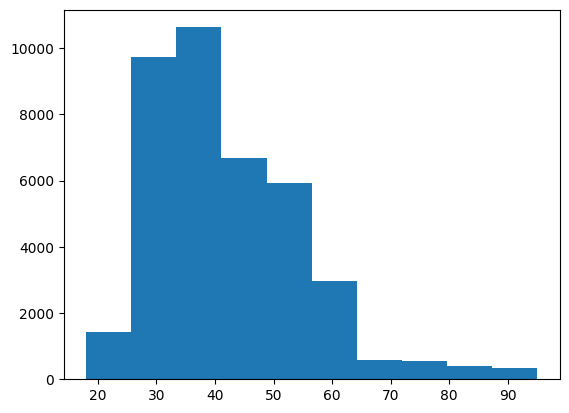

In [72]:
# Histogram
plt.hist(numerical_columns['age'])

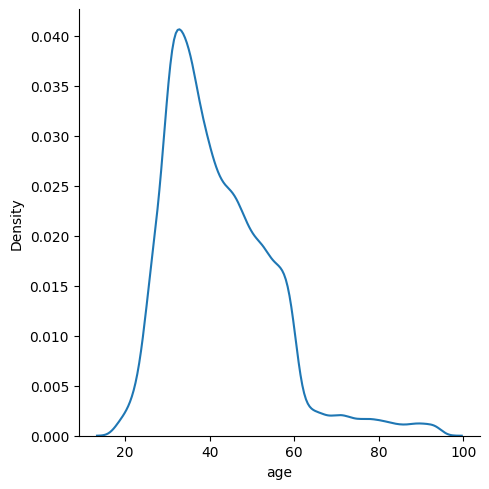

In [73]:
# Distplot
sns.displot(numerical_columns['age'], kind="kde")

In [74]:
# skewness
numerical_columns['age'].skew()

1.124277825963419

<Axes: >

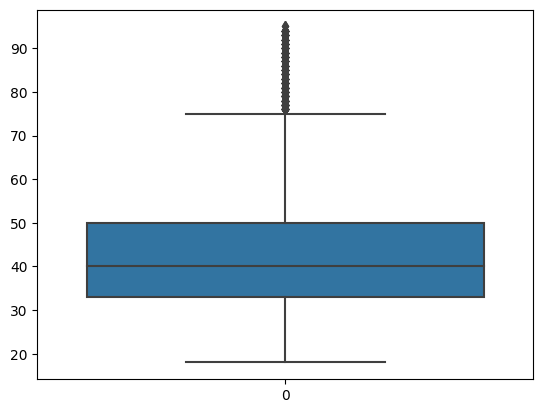

In [75]:
#Boxplot
sns.boxplot(numerical_columns['age'])

##### Conclusion¶¶¶¶¶
1. min : 18
2. max: 95
3. this column has central value around 40 (mean: 42.12, mode: 40.0)
4. 32 has highest frequency
5. column deviates from mean by ± 12 years
6. 25th percentile : 33
7. 75th percentile : 50
8. IQR : 17
9. moderately highly positivly skewed (right skewed) 
10. cloumn has outliers

### 2. **balance** Column

In [76]:
print("---------")
print("Min Balance : ", numerical_columns['balance'].min())
print("---------")
print("Max Balance : ", numerical_columns['balance'].max())
print("---------")
print("Mean Balance : ", numerical_columns['balance'].mean())
print("---------")
print("Median Balance : ", numerical_columns['balance'].median())
print("---------")
print("Mode Balance : ", numerical_columns['balance'].mode())
print("---------")
print("Std Balance : ", numerical_columns['balance'].std())
print("---------")

---------
Min Balance :  -8019
---------
Max Balance :  102127
---------
Mean Balance :  5441.78171941547
---------
Median Balance :  549.0
---------
Mode Balance :  0    0
Name: balance, dtype: int64
---------
Std Balance :  16365.292064598812
---------


In [77]:
print("---------")
# IQR Q1
Q1 = numerical_columns['balance'].quantile(0.25)
print("25th percentile of balance column: ", Q1)
print("---------")
# IQR Q2
Q3 = numerical_columns['balance'].quantile(0.75)
print("75th percentile of balance column: ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR of balance column: ", iqr)
print("---------")

---------
25th percentile of balance column:  98.0
---------
75th percentile of balance column:  2030.0
---------
IQR of balance column:  1932.0
---------


(array([31656.,  4487.,   590.,   371.,   348.,   341.,   356.,   358.,
          342.,   362.]),
 array([ -8019. ,   2995.6,  14010.2,  25024.8,  36039.4,  47054. ,
         58068.6,  69083.2,  80097.8,  91112.4, 102127. ]),
 <BarContainer object of 10 artists>)

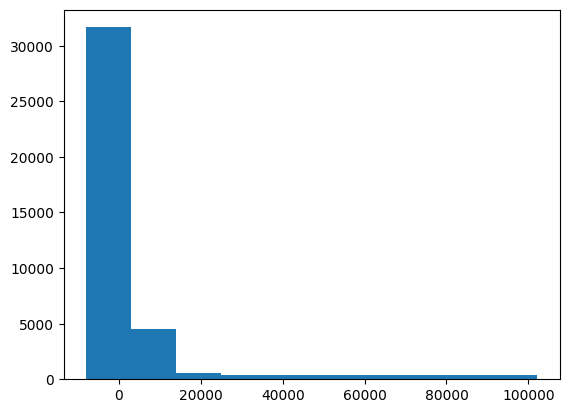

In [78]:
# Histogram
plt.hist(numerical_columns['balance'])

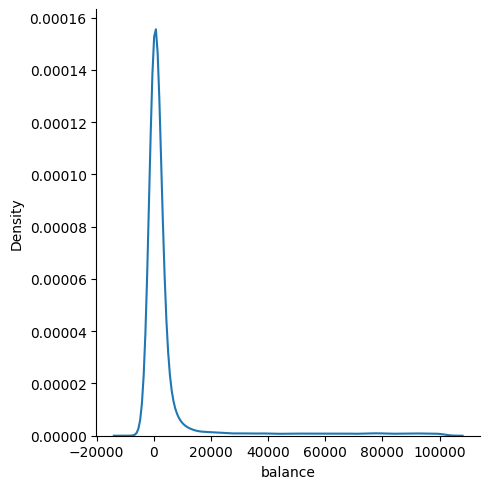

In [79]:
# Distplot
sns.displot(numerical_columns['balance'], kind="kde")

In [80]:
# skewness
numerical_columns['balance'].skew()

4.0635870169871

<Axes: >

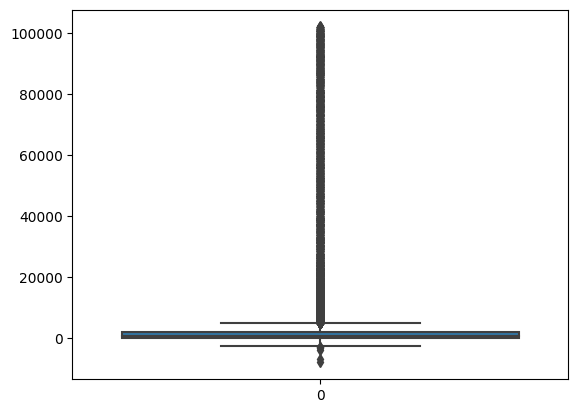

In [81]:
#Boxplot
sns.boxplot(numerical_columns['balance'])

##### Conclusion¶¶¶¶¶
1. min : -8019
2. max: 102127
3. large difference between central values (mean: 5441.78, median: 549.0, mode: 0)
5. column deviates from mean by ± 16365.29 (STD)
6. 25th percentile : 98.0
7. 75th percentile : 2030.00
8. IQR : 1932.0
9. very highly positivly skewed (right skewed)
10. many outliers present

### 3. **duration** Column

In [82]:
print("---------")
print("Min duration : ", numerical_columns['duration'].min())
print("---------")
print("Max duration : ", numerical_columns['duration'].max())
print("---------")
print("Mean duration : ", numerical_columns['duration'].mean())
print("---------")
print("Median duration : ", numerical_columns['duration'].median())
print("---------")
print("Mode duration : ", numerical_columns['duration'].mode())
print("---------")
print("Std duration : ", numerical_columns['duration'].std())
print("---------")

---------
Min duration :  0
---------
Max duration :  4918
---------
Mean duration :  439.06278850322616
---------
Median duration :  197.0
---------
Mode duration :  0    124
Name: duration, dtype: int64
---------
Std duration :  769.0962908844701
---------


In [83]:
print("---------")
# IQR Q1
Q1 = numerical_columns['duration'].quantile(0.25)
print("25th percentile of duration column: ", Q1)
print("---------")
# IQR Q2
Q3 = numerical_columns['duration'].quantile(0.75)
print("75th percentile of duration column: ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR of duration column: ", iqr)
print("---------")


---------
25th percentile of duration column:  109.0
---------
75th percentile of duration column:  380.0
---------
IQR of duration column:  271.0
---------


(array([31926.,  3822.,   986.,   476.,   360.,   349.,   320.,   343.,
          320.,   309.]),
 array([   0. ,  491.8,  983.6, 1475.4, 1967.2, 2459. , 2950.8, 3442.6,
        3934.4, 4426.2, 4918. ]),
 <BarContainer object of 10 artists>)

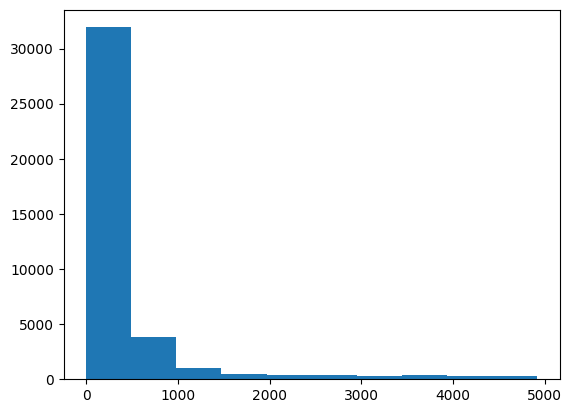

In [84]:
# Histogram
plt.hist(numerical_columns['duration'])

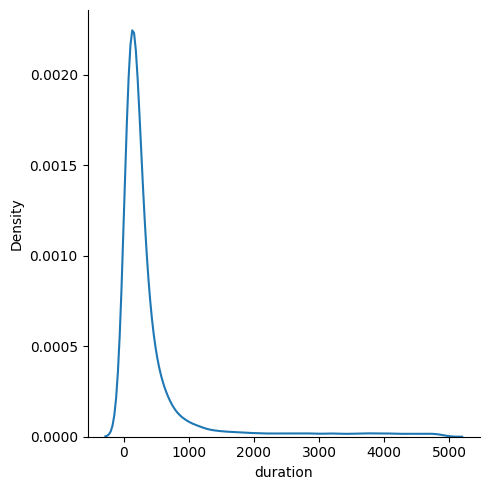

In [85]:
# Distplot
sns.displot(numerical_columns['duration'], kind="kde")

In [86]:
# skewness
numerical_columns['duration'].skew()

3.7005849290063417

<Axes: >

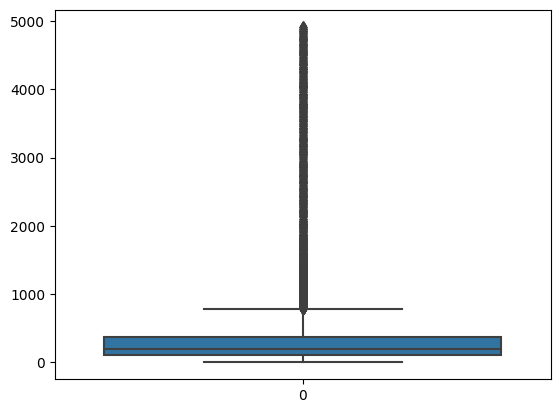

In [87]:
#Boxplot
sns.boxplot(numerical_columns['duration'])


##### Conclusion¶¶¶¶¶

1. min : 0
2. max: 4918
3. large difference between central values (mean: 439.06, median: 197.0, mode: 124)
4. samples deviates from mean by ± 769.09 (STD)
5. 25th percentile : 109.0
6. 75th percentile : 380.0
7. IQR : 271.0
8. very highly positivly skewed (right skewed) (skewness : 3.70)
9. too many outliers present



### 4. **campaign** Column

In [88]:
print("---------")
print("Min campaign : ", numerical_columns['campaign'].min())
print("---------")
print("Max campaign : ", numerical_columns['campaign'].max())
print("---------")
print("Mean campaign : ", numerical_columns['campaign'].mean())
print("---------")
print("Median campaign : ", numerical_columns['campaign'].median())
print("---------")
print("Mode campaign : ", numerical_columns['campaign'].mode())
print("---------")
print("Std campaign : ", numerical_columns['campaign'].std())
print("---------")

---------
Min campaign :  1
---------
Max campaign :  63
---------
Mean campaign :  5.10877049807452
---------
Median campaign :  2.0
---------
Mode campaign :  0    1
Name: campaign, dtype: int64
---------
Std campaign :  9.89015298596731
---------


In [89]:
print("---------")
# IQR Q1
Q1 = numerical_columns['campaign'].quantile(0.25)
print("25th percentile of campaign column: ", Q1)
print("---------")
# IQR Q2
Q3 = numerical_columns['campaign'].quantile(0.75)
print("75th percentile of campaign column: ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR of campaign column: ", iqr)
print("---------")


---------
25th percentile of campaign column:  1.0
---------
75th percentile of campaign column:  4.0
---------
IQR of campaign column:  3.0
---------


(array([34535.,  1612.,   636.,   418.,   362.,   390.,   310.,   321.,
          294.,   333.]),
 array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ]),
 <BarContainer object of 10 artists>)

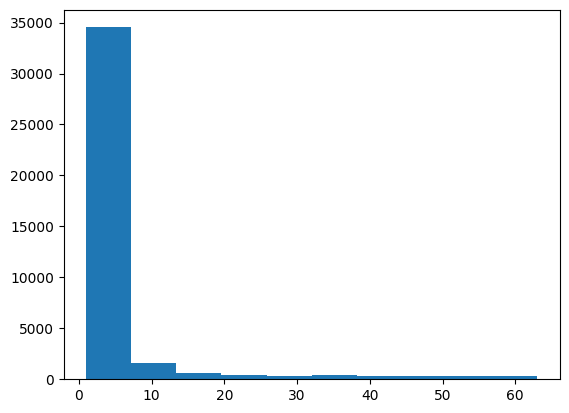

In [90]:
# Histogram
plt.hist(numerical_columns['campaign'])

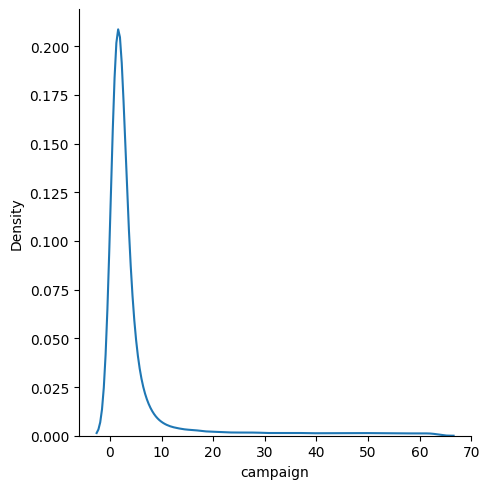

In [91]:
# Distplot
sns.displot(numerical_columns['campaign'], kind="kde")

In [92]:
# Skewness
numerical_columns['campaign'].skew()

3.839592516972888

<Axes: >

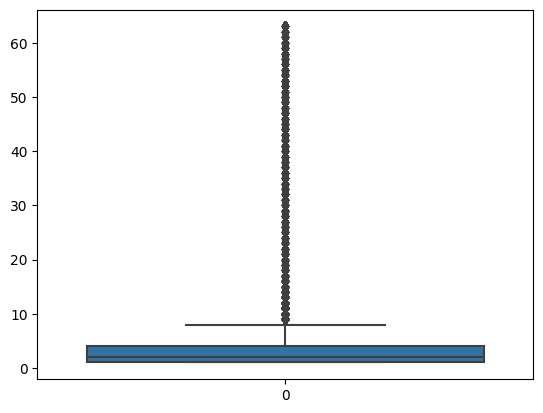

In [93]:
#Boxplot
sns.boxplot(numerical_columns['campaign'])

##### Conclusion¶¶¶¶¶
1. min : 1
2. max: 63
3. large difference between central values (mean: 5.10, median: 2.0, mode: 1)
4. samples deviates from mean by ± 9.89 (STD)
5. 25th percentile : 1.0
6. 75th percentile : 4.0
7. IQR : 3.0
8. very highly positivly skewed (right skewed) (skewness : 3.83)
9. too many outliers present

### 5. **pdays** Coulmn

In [94]:
print("---------")
print("Min pdays : ", numerical_columns['pdays'].min())
print("---------")
print("Max pdays : ", numerical_columns['pdays'].max())
print("---------")
print("Mean pdays : ", numerical_columns['pdays'].mean())
print("---------")
print("Median pdays : ", numerical_columns['pdays'].median())
print("---------")
print("Mode pdays : ", numerical_columns['pdays'].mode())
print("---------")
print("Std pdays : ", numerical_columns['pdays'].std())
print("---------")

---------
Min pdays :  -1
---------
Max pdays :  871
---------
Mean pdays :  72.25605059804647
---------
Median pdays :  -1.0
---------
Mode pdays :  0   -1
Name: pdays, dtype: int64
---------
Std pdays :  160.94259339618398
---------


In [95]:
print("---------")
# IQR Q1
Q1 = numerical_columns['pdays'].quantile(0.25)
print("25th percentile of pdays column: ", Q1)
print("---------")
# IQR Q2
Q3 = numerical_columns['pdays'].quantile(0.75)
print("75th percentile of pdays column: ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR of pdays column: ", iqr)
print("---------")

---------
25th percentile of pdays column:  -1.0
---------
75th percentile of pdays column:  -1.0
---------
IQR of pdays column:  0.0
---------


(array([30187.,  2190.,  2017.,  1746.,  1319.,   430.,   342.,   328.,
          325.,   327.]),
 array([ -1. ,  86.2, 173.4, 260.6, 347.8, 435. , 522.2, 609.4, 696.6,
        783.8, 871. ]),
 <BarContainer object of 10 artists>)

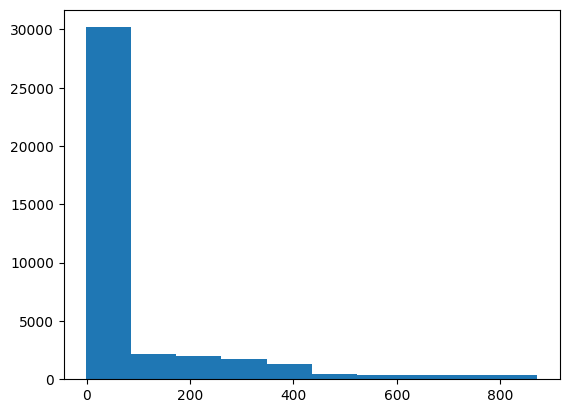

In [96]:
# Histogram
plt.hist(numerical_columns['pdays'])

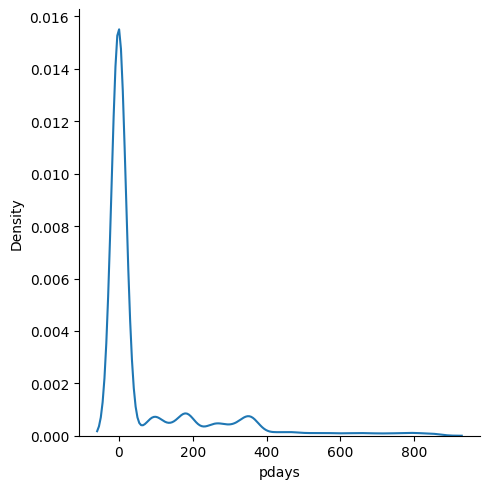

In [97]:
# Distplot
sns.displot(numerical_columns['pdays'], kind="kde")

In [98]:
# Skewness
numerical_columns['pdays'].skew()

2.6117734927706215

<Axes: >

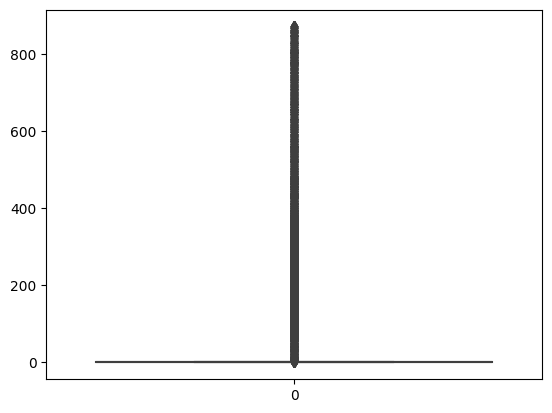

In [99]:
#Boxplot
sns.boxplot(numerical_columns['pdays'])

##### Conclusion¶¶¶¶¶
1. min : -1
2. max: 871
3. large difference between central values (mean: 72.25, median: -1.0, mode: -1)
4. samples deviates from mean by ± 160.94 (STD)
5. 25th percentile : -1.0
6. 75th percentile : -1.0
7. IQR : 0.0
8. very highly positivly skewed (right skewed) (skewness : 2.61)
9. too many outliers present

### 6. **previous** Column

In [100]:
print("---------")
print("Min previous : ", numerical_columns['previous'].min())
print("---------")
print("Max previous : ", numerical_columns['previous'].max())
print("---------")
print("Mean previous : ", numerical_columns['previous'].mean())
print("---------")
print("Median previous : ", numerical_columns['previous'].median())
print("---------")
print("Mode previous : ", numerical_columns['previous'].mode())
print("---------")
print("Std previous : ", numerical_columns['previous'].std())
print("---------")

---------
Min previous :  0
---------
Max previous :  275
---------
Mean previous :  11.826171227461682
---------
Median previous :  0.0
---------
Mode previous :  0    0
Name: previous, dtype: int64
---------
Std previous :  44.14025869568701
---------


In [101]:
print("---------")
# IQR Q1
Q1 = numerical_columns['previous'].quantile(0.25)
print("25th percentile of previous column: ", Q1)
print("---------")
# IQR Q2
Q3 = numerical_columns['previous'].quantile(0.75)
print("75th percentile of previous column: ", Q3)
print("---------")
# IQR
iqr = Q3 - Q1
print("IQR of previous column: ", iqr)
print("---------")

---------
25th percentile of previous column:  0.0
---------
75th percentile of previous column:  0.0
---------
IQR of previous column:  0.0
---------


(array([36309.,   312.,   336.,   326.,   319.,   309.,   320.,   331.,
          311.,   338.]),
 array([  0. ,  27.5,  55. ,  82.5, 110. , 137.5, 165. , 192.5, 220. ,
        247.5, 275. ]),
 <BarContainer object of 10 artists>)

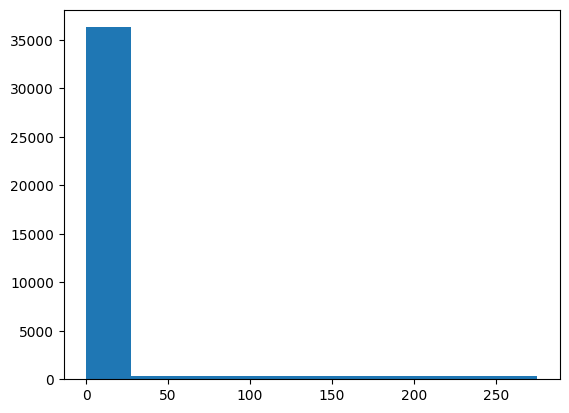

In [102]:
# Histogram
plt.hist(numerical_columns['previous'])

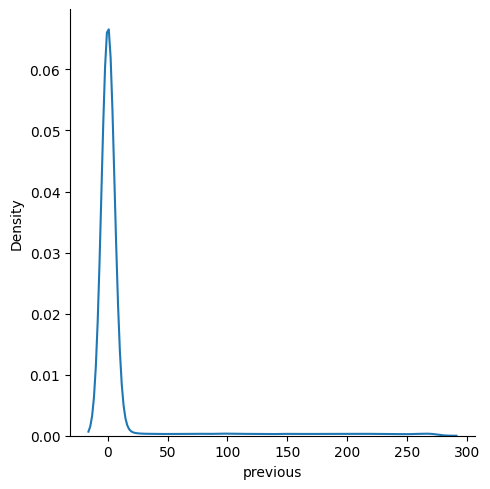

In [103]:
# Distplot
sns.displot(numerical_columns['previous'], kind="kde")

In [104]:
# Skewness
numerical_columns['previous'].skew()

4.206572876950425

<Axes: >

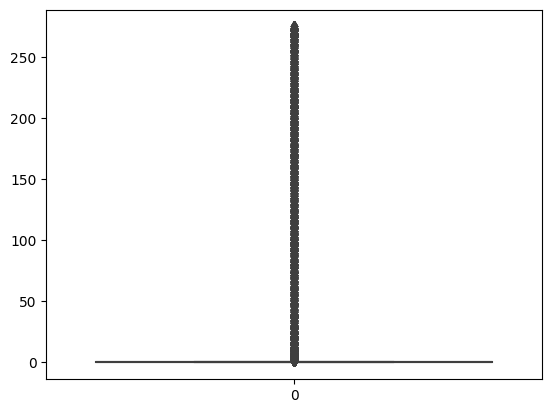

In [105]:
#Boxplot
sns.boxplot(numerical_columns['previous'])

##### Conclusion¶¶¶¶¶
1. min : 0
2. max: 275
3. large difference between central values (mean: 11.82, median: 0.0, mode: 0)
4. samples deviates from mean by ± 44.14 (STD)
5. 25th percentile : 0.0
6. 75th percentile : 0.0
7. IQR : 0.0
8. very highly positivly skewed (right skewed) (skewness : 4.20)
9. too many outliers present

## Insights

1. All Numarical Columns have right skewed data
2. Outliers present in the following features, **(age, balance, duration, campaign, pdays, previous)**

# EDA - Bivariate Analysis

In [106]:
train_df.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

## Numerical Columns Coreleations

In [107]:
numerical_columns.corr()

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.289150,0.255573,0.269439,0.199507,0.277487
balance,0.289150,1.000000,0.669737,0.674339,0.562097,0.716816
duration,0.255573,0.669737,1.000000,0.630944,0.527020,0.683951
campaign,0.269439,0.674339,0.630944,1.000000,0.519469,0.689211
pdays,0.199507,0.562097,0.527020,0.519469,1.000000,0.586175
previous,0.277487,0.716816,0.683951,0.689211,0.586175,1.000000


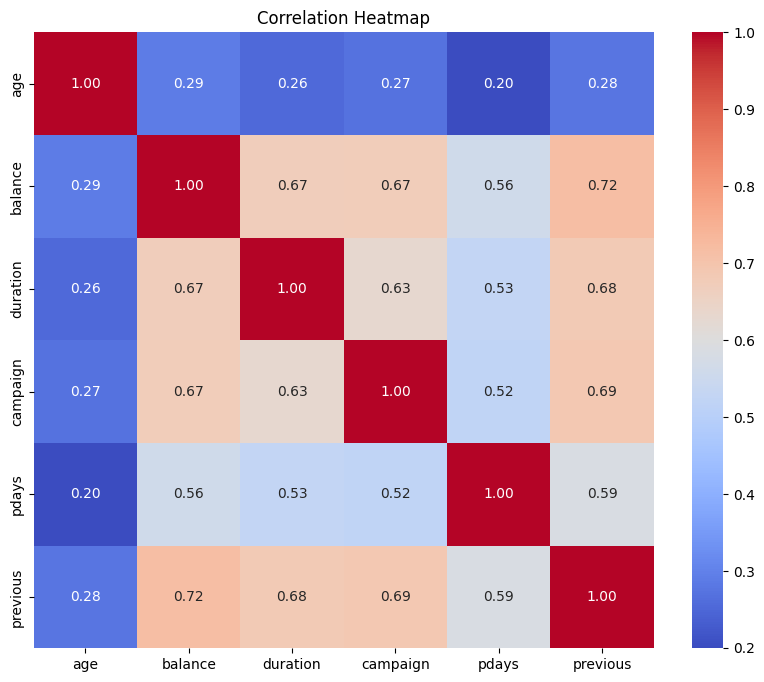

In [108]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

#### Conclusion
1. all columns have +ve co-releation with each other
2. Low co-releation columns: (age, balance), (age, duration), (age,campaign), (age, pdays), (age, previous)
3. Moderate co-releation columns: (balance, duration), (balance, campaign), (balance, pdays), (duration, campaign), (duration, pdays), (duration, previous), (campaign, pdays), (campaign, previous), (pdays, previous)
4. High co-releation columns: (balance, previous)

# Feature Engineering

In [109]:
# Feature , label split
# training set
X = train_df.drop(columns='target')
y = train_df['target']

In [110]:
X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=0.2,random_state=0)

In [111]:
X_train

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
7362,2008-05-09,42,blue-collar,married,secondary,no,117,yes,no,NaN,147,1,-1,0,NaN
32857,2008-07-22,27,blue-collar,married,primary,no,300,no,yes,cellular,209,2,-1,0,NaN
28964,2009-05-15,41,self-employed,married,secondary,no,149,yes,no,NaN,27,1,-1,0,NaN
6629,2010-07-07,44,housemaid,married,primary,no,398,no,no,cellular,187,3,-1,0,NaN
631,2010-04-09,36,blue-collar,single,secondary,no,5396,yes,no,cellular,490,2,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,2008-02-10,36,technician,married,tertiary,no,99,yes,yes,cellular,86,1,85,1,failure
32103,2009-11-21,41,management,married,tertiary,no,9935,no,no,telephone,49,1,-1,0,NaN
30403,2010-05-13,37,technician,single,secondary,no,267,no,no,cellular,121,1,-1,0,NaN
21243,2010-05-14,42,admin.,single,secondary,no,243,yes,no,NaN,46,5,-1,0,NaN


In [112]:
y_train

7362      no
32857     no
28964     no
6629      no
631       no
        ... 
20757     no
32103     no
30403     no
21243     no
2732     yes
Name: target, Length: 31368, dtype: object

In [113]:
X_validation

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
19138,2008-05-20,29,services,single,secondary,no,271,yes,no,NaN,1882,2,-1,0,NaN
21703,2009-07-08,36,unemployed,divorced,secondary,no,5,yes,no,cellular,305,1,-1,0,NaN
32089,2008-05-14,35,blue-collar,single,primary,no,1284,yes,no,telephone,13,5,-1,0,NaN
19762,2008-05-27,29,blue-collar,married,secondary,no,2776,yes,no,NaN,233,1,-1,0,NaN
13970,2010-01-29,26,management,divorced,tertiary,yes,-402,no,yes,cellular,66,2,262,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36432,2008-11-19,35,unemployed,married,tertiary,no,816,yes,no,cellular,547,7,-1,0,NaN
30167,2008-02-06,44,technician,single,secondary,no,196,yes,no,cellular,386,3,-1,0,NaN
10367,2010-05-16,35,technician,married,secondary,no,523,yes,yes,NaN,95,1,-1,0,NaN
6783,2009-06-06,44,blue-collar,single,secondary,no,259,yes,no,NaN,163,2,-1,0,NaN


In [114]:
y_validation

19138    yes
21703     no
32089     no
19762     no
13970     no
        ... 
36432     no
30167     no
10367     no
6783      no
8698     yes
Name: target, Length: 7843, dtype: object

## Handling Missing Values

In [115]:
miss_training = X_train.copy()
miss_validation = X_validation.copy()
miss_testing = test_df.copy()

### 1. 'job' column - (0.58% missing)

<Axes: xlabel='job'>

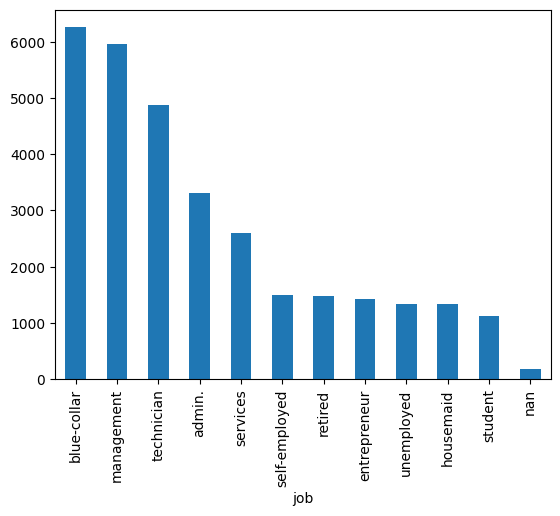

In [116]:
miss_training['job'].value_counts(dropna=False).plot(kind='bar')

We are filling the missing values with the mode of the column. Although a few other categories have value counts close to the mode, the percentage of missing values is quite low, so replacing them with the mode is a reasonable approach.


In [117]:
mode_value = miss_training['job'].mode()[0]
print("Mode : ", mode_value)

Mode :  blue-collar


In [118]:
# Mode imputation for 'job'
job_imputer = SimpleImputer(strategy='most_frequent')

In [119]:
# Apply imputation on the 'job' column and flatten the result to 1D
miss_training['job'] = job_imputer.fit_transform(miss_training[['job']]).ravel()
miss_validation['job'] = job_imputer.fit_transform(miss_validation[['job']]).ravel()
miss_testing['job'] = job_imputer.fit_transform(miss_testing[['job']]).ravel()

In [120]:
# Verify if the imputation worked on training set
print("Missing values successfully imputed in 'job' column of training set.")
print(miss_training['job'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'job' column of training set.
0


In [121]:
# Verify if the imputation worked on validation set
print("Missing values successfully imputed in 'job' column of validation set.")
print(miss_validation['job'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'job' column of validation set.
0


In [122]:
# Verify if the imputation worked
print("Missing values successfully imputed in 'job' column of test set.")
print(miss_testing['job'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'job' column of test set.
0


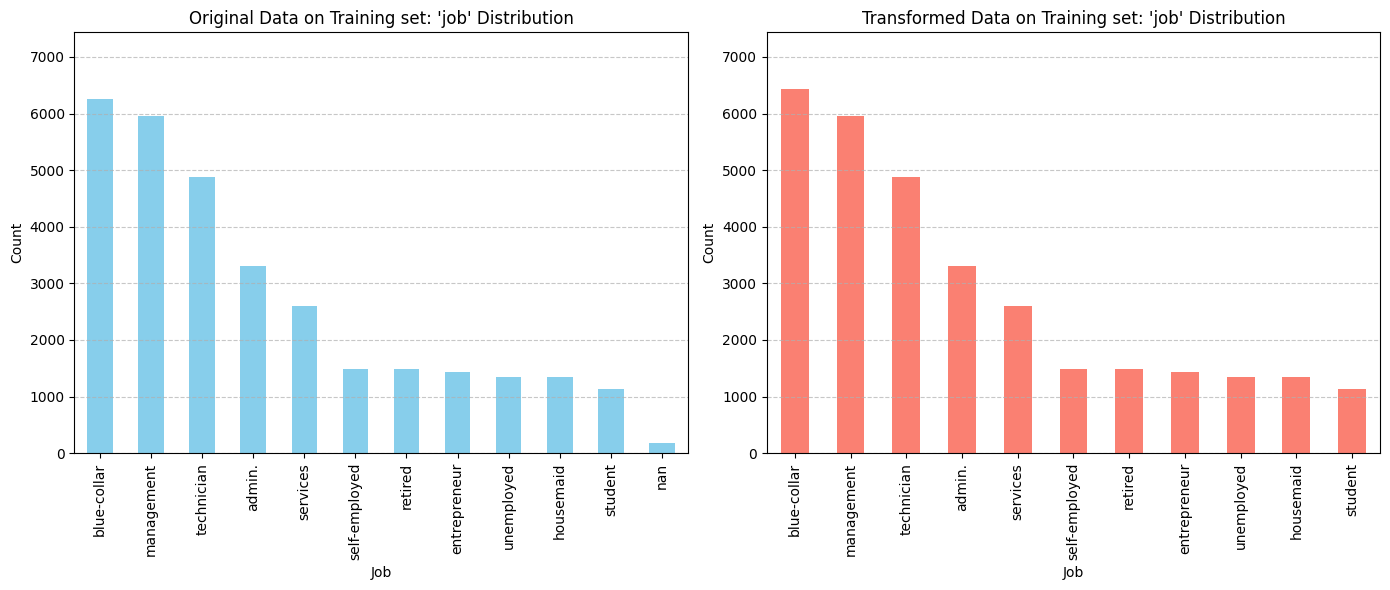

In [123]:
# Find the maximum y-axis limit for both datasets
max_count = max(X_train['job'].value_counts().max(), miss_training['job'].value_counts().max()) + 1000

# Set up the figure and subplots
plt.figure(figsize=(14, 6))

# Plot for the original data
plt.subplot(1, 2, 1)
X_train['job'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title("Original Data on Training set: 'job' Distribution")
plt.xlabel('Job')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

# Plot for the transformed data
plt.subplot(1, 2, 2)
miss_training['job'].value_counts(dropna=False).plot(kind='bar', color='salmon')
plt.title("Transformed Data on Training set: 'job' Distribution")
plt.xlabel('Job')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

plt.tight_layout()
plt.show()

### 2. 'education' column - (3.74% missing)


<Axes: xlabel='education'>

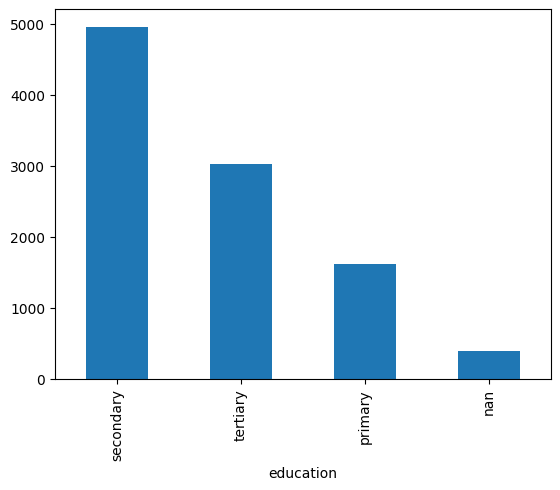

In [124]:
miss_testing['education'].value_counts(dropna=False).plot(kind='bar')

In [125]:
mode_value = miss_testing['education'].mode()[0]
print("Mode : ", mode_value)

Mode :  secondary


In [126]:
# Mode imputation for 'education'
edu_imputer = SimpleImputer(strategy='most_frequent')

We will fill nan values with mode. Although a few other categories have value counts close to the mode, the percentage of missing values is quite low, so replacing them with the mode is a reasonable approach.

In [127]:
# Apply imputation on the 'education' column and flatten the result to 1D
miss_training['education'] = edu_imputer.fit_transform(miss_training[['education']]).ravel()
miss_validation['education'] = edu_imputer.fit_transform(miss_validation[['education']]).ravel()
miss_testing['education'] = edu_imputer.fit_transform(miss_testing[['education']]).ravel()

In [128]:
# Verify if the imputation worked on training set
print("Missing values successfully imputed in 'education' column of training set.")
print(miss_training['education'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'education' column of training set.
0


In [129]:
# Verify if the imputation worked on training set
print("Missing values successfully imputed in 'education' column of miss_validation set.")
print(miss_validation['education'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'education' column of miss_validation set.
0


In [130]:
# Verify if the imputation worked on test set
print("Missing values successfully imputed in 'education' column of test set.")
print(miss_testing['education'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'education' column of test set.
0


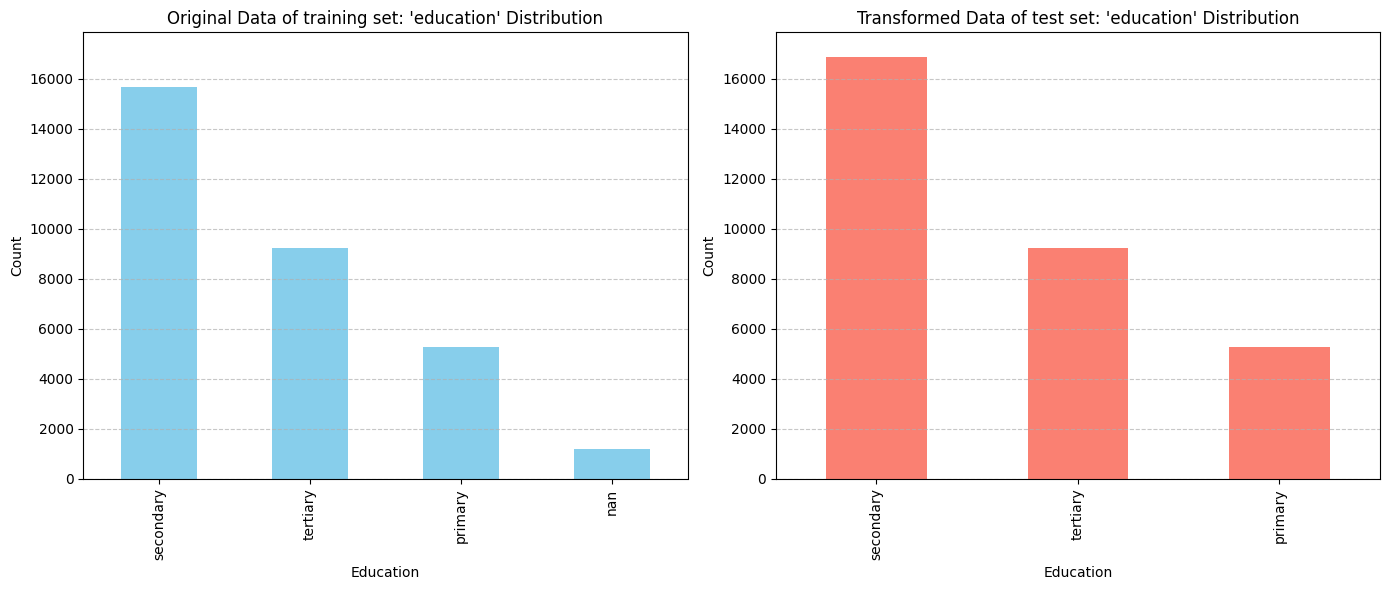

In [131]:
# Find the maximum y-axis limit for both datasets
max_count = max(X_train['education'].value_counts().max(), miss_training['education'].value_counts().max()) + 1000

# Set up the figure and subplots
plt.figure(figsize=(14, 6))

# Plot for the original data
plt.subplot(1, 2, 1)
X_train['education'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title("Original Data of training set: 'education' Distribution")
plt.xlabel('Education')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

# Plot for the transformed data
plt.subplot(1, 2, 2)
miss_training['education'].value_counts(dropna=False).plot(kind='bar', color='salmon')
plt.title("Transformed Data of test set: 'education' Distribution")
plt.xlabel('Education')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

plt.tight_layout()
plt.show()

### 3. 'contact' column - (26.35% missing)


<Axes: xlabel='contact'>

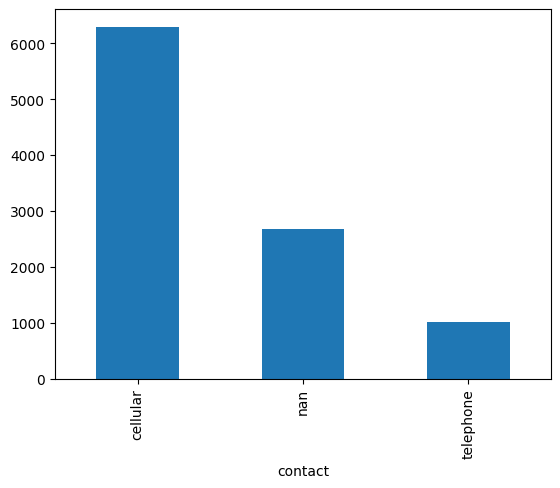

In [132]:
miss_testing['contact'].value_counts(dropna=False).plot(kind='bar')

Given the moderately high amount of missing data, imputing with the mode isn’t ideal. Therefore, we will replace the np.nan values with the label 'Unknown'.


In [133]:
# Mode imputation for 'education'
contact_imputer = SimpleImputer(strategy='constant',fill_value='Unknown')

In [134]:
# Apply imputation on the 'education' column and flatten the result to 1D
miss_training['contact'] = contact_imputer.fit_transform(miss_training[['contact']]).ravel()
miss_validation['contact'] = contact_imputer.fit_transform(miss_validation[['contact']]).ravel()
miss_testing['contact'] = contact_imputer.fit_transform(miss_testing[['contact']]).ravel()

In [135]:
# Verify if the imputation worked on training set
print("Missing values successfully imputed in 'contact' column of training set.")
print(miss_training['contact'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'contact' column of training set.
0


In [136]:
# Verify if the imputation worked on validation set
print("Missing values successfully imputed in 'contact' column of training set.")
print(miss_validation['contact'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'contact' column of training set.
0


In [137]:
# Verify if the imputation worked
print("Missing values successfully imputed in 'contact' column of test set.")
print(miss_testing['contact'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'contact' column of test set.
0


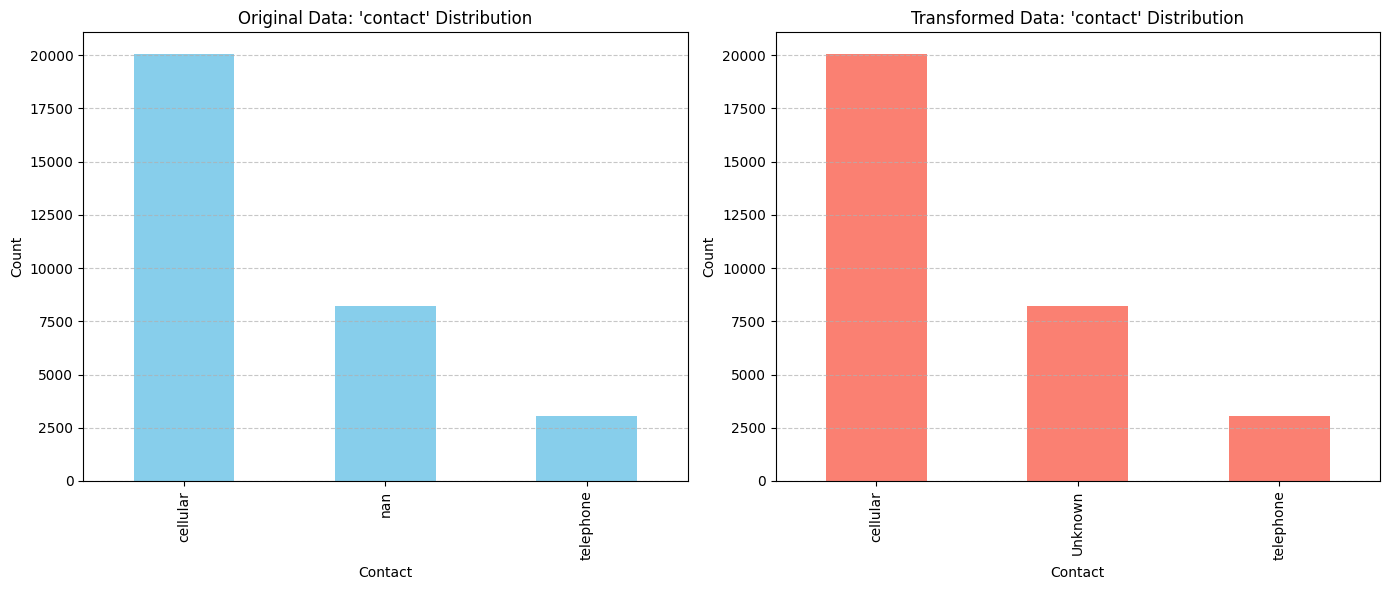

In [138]:
# Find the maximum y-axis limit for both datasets
max_count = max(X_train['contact'].value_counts().max(), miss_training['contact'].value_counts().max()) + 1000

# Set up the figure and subplots
plt.figure(figsize=(14, 6))

# Plot for the original data
plt.subplot(1, 2, 1)
X_train['contact'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title("Original Data: 'contact' Distribution")
plt.xlabel('Contact')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

# Plot for the transformed data
plt.subplot(1, 2, 2)
miss_training['contact'].value_counts(dropna=False).plot(kind='bar', color='salmon')
plt.title("Transformed Data: 'contact' Distribution")
plt.xlabel('Contact')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

plt.tight_layout()
plt.show()

### 4. 'poutcome' column - (75.10% missing)

Due to the substantial amount of missing data, relying on this column may distort our predictions. Therefore, we will simply drop this column.

<Axes: xlabel='poutcome'>

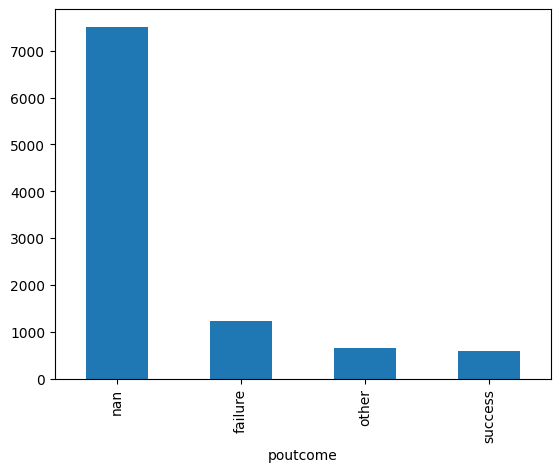

In [139]:
miss_testing['poutcome'].value_counts(dropna=False).plot(kind='bar')

In [140]:
# Mode imputation for 'education'
poutcome_imputer = SimpleImputer(strategy='constant',fill_value='Unknown')

In [141]:
# Apply imputation on the 'education' column and flatten the result to 1D
miss_training['poutcome'] = contact_imputer.fit_transform(miss_training[['poutcome']]).ravel()
miss_validation['poutcome'] = contact_imputer.fit_transform(miss_validation[['poutcome']]).ravel()
miss_testing['poutcome'] = contact_imputer.fit_transform(miss_testing[['poutcome']]).ravel()

In [142]:
# Verify if the imputation worked on training set
print("Missing values successfully imputed in 'poutcome' column of training set.")
print(miss_training['poutcome'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'poutcome' column of training set.
0


In [143]:
# Verify if the imputation worked on validation set
print("Missing values successfully imputed in 'contact' column of training set.")
print(miss_validation['poutcome'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'contact' column of training set.
0


In [144]:
# Verify if the imputation worked
print("Missing values successfully imputed in 'contact' column of test set.")
print(miss_testing['poutcome'].isnull().sum())  # Should print 0 if imputation was successful

Missing values successfully imputed in 'contact' column of test set.
0


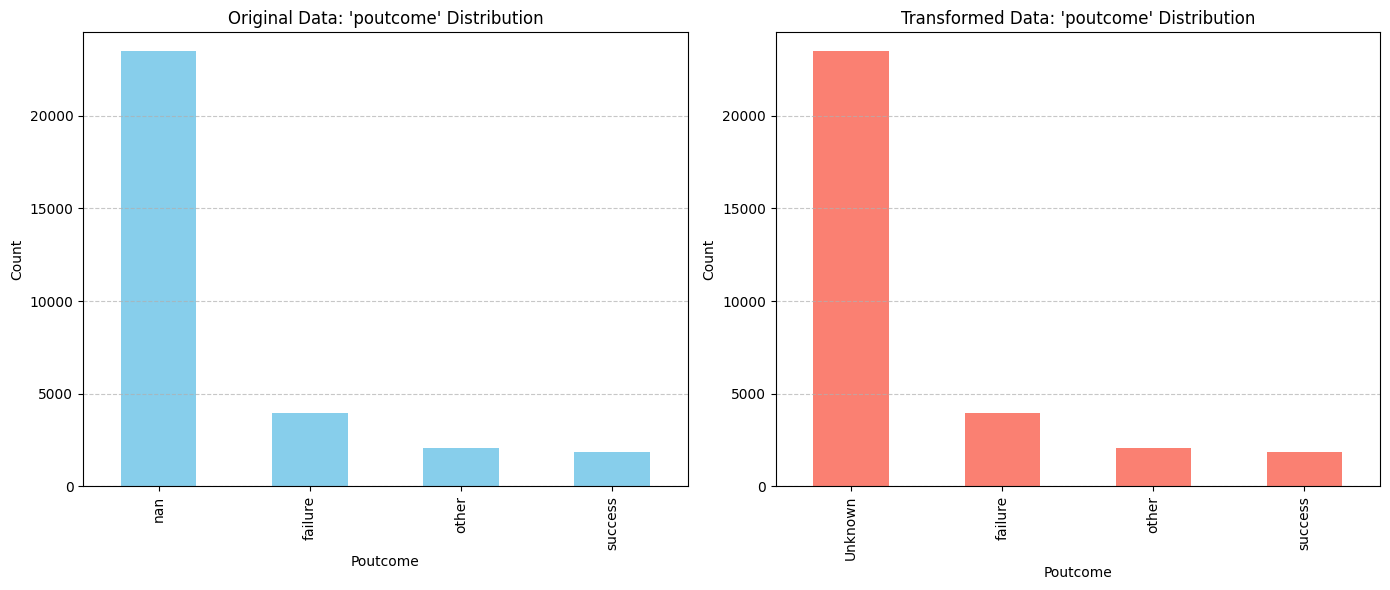

In [145]:
# Find the maximum y-axis limit for both datasets
max_count = max(X_train['poutcome'].value_counts().max(), miss_training['poutcome'].value_counts().max()) + 1000

# Set up the figure and subplots
plt.figure(figsize=(14, 6))

# Plot for the original data
plt.subplot(1, 2, 1)
X_train['poutcome'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title("Original Data: 'poutcome' Distribution")
plt.xlabel('Poutcome')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

# Plot for the transformed data
plt.subplot(1, 2, 2)
miss_training['poutcome'].value_counts(dropna=False).plot(kind='bar', color='salmon')
plt.title("Transformed Data: 'poutcome' Distribution")
plt.xlabel('Poutcome')
plt.ylabel('Count')
plt.ylim(0, max_count)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on y-axis

plt.tight_layout()
plt.show()

### Updating Dataframe

In [146]:
miss_training.isnull().sum()

last contact date    0
age                  0
job                  0
marital              0
education            0
default              0
balance              0
housing              0
loan                 0
contact              0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
dtype: int64

In [147]:
miss_validation.isnull().sum()

last contact date    0
age                  0
job                  0
marital              0
education            0
default              0
balance              0
housing              0
loan                 0
contact              0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
dtype: int64

In [148]:
miss_testing.isnull().sum()

last contact date    0
age                  0
job                  0
marital              0
education            0
default              0
balance              0
housing              0
loan                 0
contact              0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
dtype: int64

In [149]:
X_train = miss_training
X_validation = miss_validation
test_df = miss_testing

## Feature Transformation

In [150]:
X_train_trf = X_train.copy()
X_validation_trf = X_validation.copy()
test_df_trf = test_df.copy()

In [151]:
epsilon = 1e-6  # Small constant to avoid division by zero

def reciprocal_transform(x):
    return 1 / (x + epsilon)

In [152]:
def plot_original_vs_transformed(original_df, transformed_df, columns):
    # Loop over each column in the provided list
    for column in columns:
        # Calculate skewness for original and transformed data
        original_skewness = original_df[column].skew()
        transformed_skewness = transformed_df[column].skew()
        
        # Set up a figure with 1 row and 2 columns for side-by-side comparison
        plt.figure(figsize=(14, 6))

        # Plot original data
        plt.subplot(1, 2, 1)
        sns.kdeplot(original_df[column], fill=True)
        plt.title(f'Original {column} Distribution\nSkewness: {original_skewness:.2f}')
        plt.xlabel(column)
        plt.ylabel('Density')

        # Plot transformed data
        plt.subplot(1, 2, 2)
        sns.kdeplot(transformed_df[column], fill=True)
        plt.title(f'Transformed {column} Distribution\nSkewness: {transformed_skewness:.2f}')
        plt.xlabel(column)
        plt.ylabel('Density')

        # Display the plots
        plt.tight_layout()
        plt.show()

In [153]:
# Function to apply transformations conditionally
def apply_best_transformation(df, columns):
    # Create a copy of the DataFrame to store transformations
    df_transformed = df.copy()
    transformation_stats = {}

    for col in columns:
        original_skew = df[col].skew()
        
        # Log transform if data is positive
        if df[col].min() > 0:
            log_transformed = np.log(df[col])
            log1p_transformed = np.log1p(df[col])
        else:
            log_transformed = None
            log1p_transformed = None

        # Reciprocal transform (with epsilon adjustment for zero or near-zero values)
        reciprocal_transformed = reciprocal_transform(df[col])

        # Box-Cox transform for positive values
        if df[col].min() > 0:
            box_cox_transformer = PowerTransformer(method='box-cox')
            box_cox_transformed = box_cox_transformer.fit_transform(df[[col]])
        else:
            box_cox_transformed = None

        # Yeo-Johnson transform (supports both positive and negative values)
        yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
        yeo_johnson_transformed = yeo_johnson_transformer.fit_transform(df[[col]])

        # Calculate skewness after transformations
        transformed_skews = {
            "original": original_skew,
            "log": log_transformed.skew() if log_transformed is not None else None,
            "log1p": log1p_transformed.skew() if log1p_transformed is not None else None,
            "reciprocal": pd.Series(reciprocal_transformed).skew(),
            "box-cox": pd.Series(box_cox_transformed.flatten()).skew() if box_cox_transformed is not None else None,
            "yeo-johnson": pd.Series(yeo_johnson_transformed.flatten()).skew()
        }
        
        # Choose the transformation with the skew closest to zero
        best_transformation = min(transformed_skews, key=lambda x: abs(transformed_skews[x]) if transformed_skews[x] is not None else float('inf'))
        
        # Apply the best transformation
        if best_transformation == "log":
            df_transformed[col] = log_transformed
        elif best_transformation == "log1p":
            df_transformed[col] = log1p_transformed
        elif best_transformation == "reciprocal":
            df_transformed[col] = reciprocal_transformed
        elif best_transformation == "box-cox":
            df_transformed[col] = box_cox_transformed.flatten()
        elif best_transformation == "yeo-johnson":
            df_transformed[col] = yeo_johnson_transformed.flatten()

        # Store the transformation stats
        transformation_stats[col] = {
            "best_transformation": best_transformation,
            "original_skew": original_skew,
            "transformed_skew": transformed_skews[best_transformation]
        }

    return df_transformed, transformation_stats

In [154]:
columns_to_transform = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']  # Specify your columns here

In [155]:
X_train_trf, stats = apply_best_transformation(X_train_trf, columns_to_transform)

# Display the stats to understand the skewness reduction
for col, info in stats.items():
    print(f"Column: {col}")
    print(f"  Best Transformation: {info['best_transformation']}")
    print(f"  Original Skew: {info['original_skew']}")
    print(f"  Transformed Skew: {info['transformed_skew']}")

Column: age
  Best Transformation: box-cox
  Original Skew: 1.1166099047855094
  Transformed Skew: 0.007458732391080521
Column: balance
  Best Transformation: yeo-johnson
  Original Skew: 4.064415556547089
  Transformed Skew: -2.446293821004067
Column: duration
  Best Transformation: yeo-johnson
  Original Skew: 3.69957103350594
  Transformed Skew: -0.020584674515778223
Column: campaign
  Best Transformation: reciprocal
  Original Skew: 3.844482393129744
  Transformed Skew: 0.13824554135081504
Column: pdays
  Best Transformation: yeo-johnson
  Original Skew: 2.607232015320197
  Transformed Skew: 1.1567921550112257
Column: previous
  Best Transformation: reciprocal
  Original Skew: 4.199409479096003
  Transformed Skew: -1.152205491036563


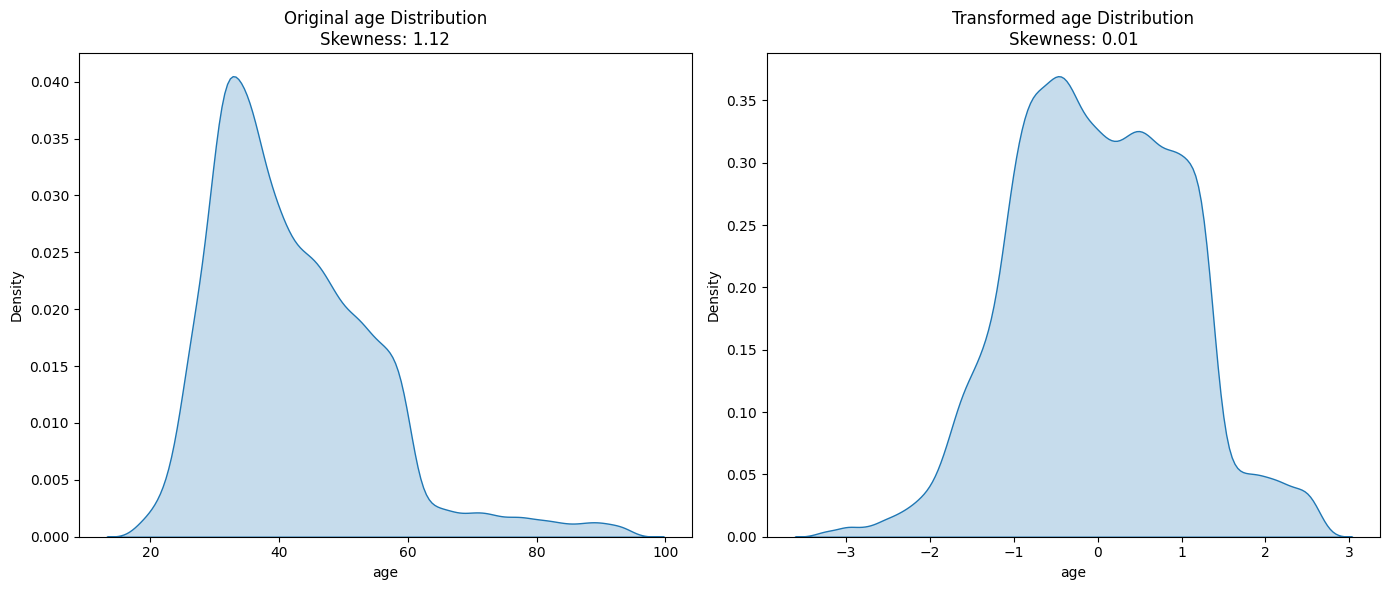

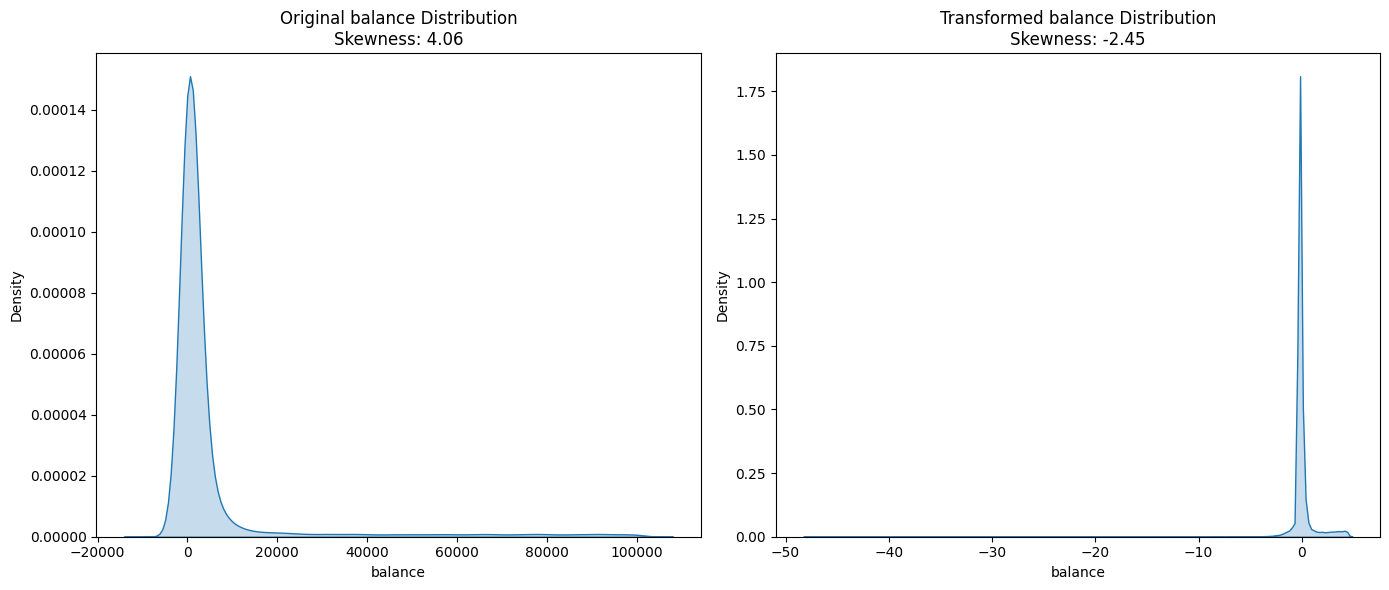

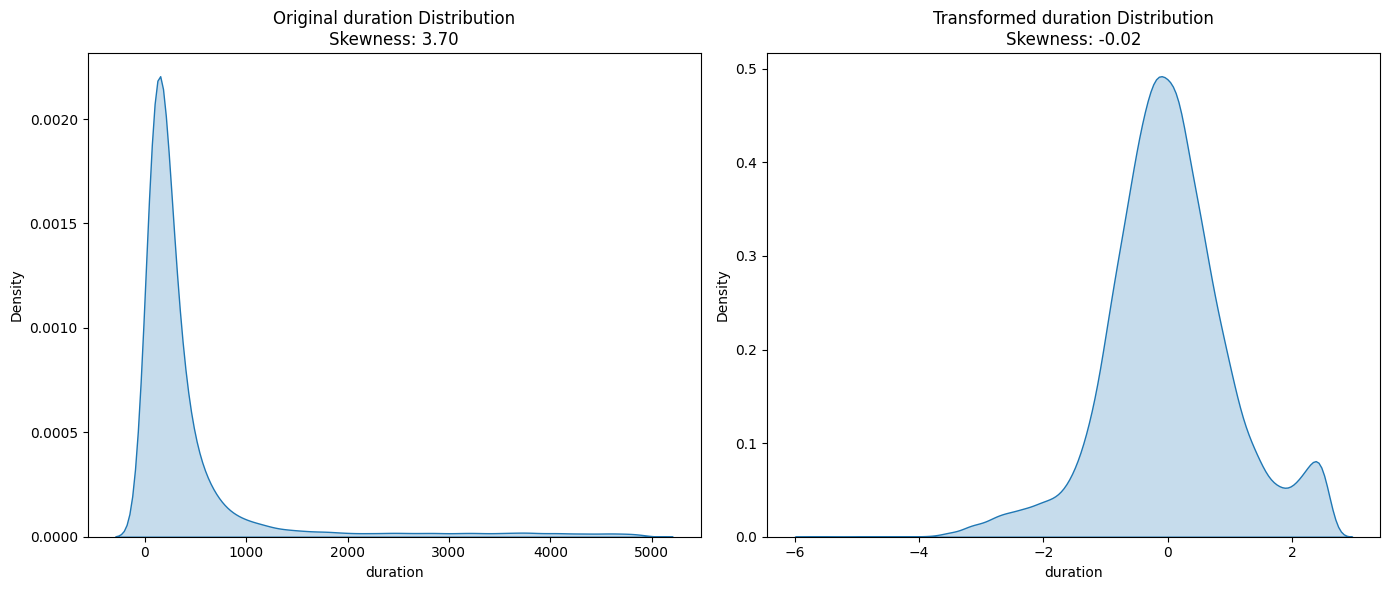

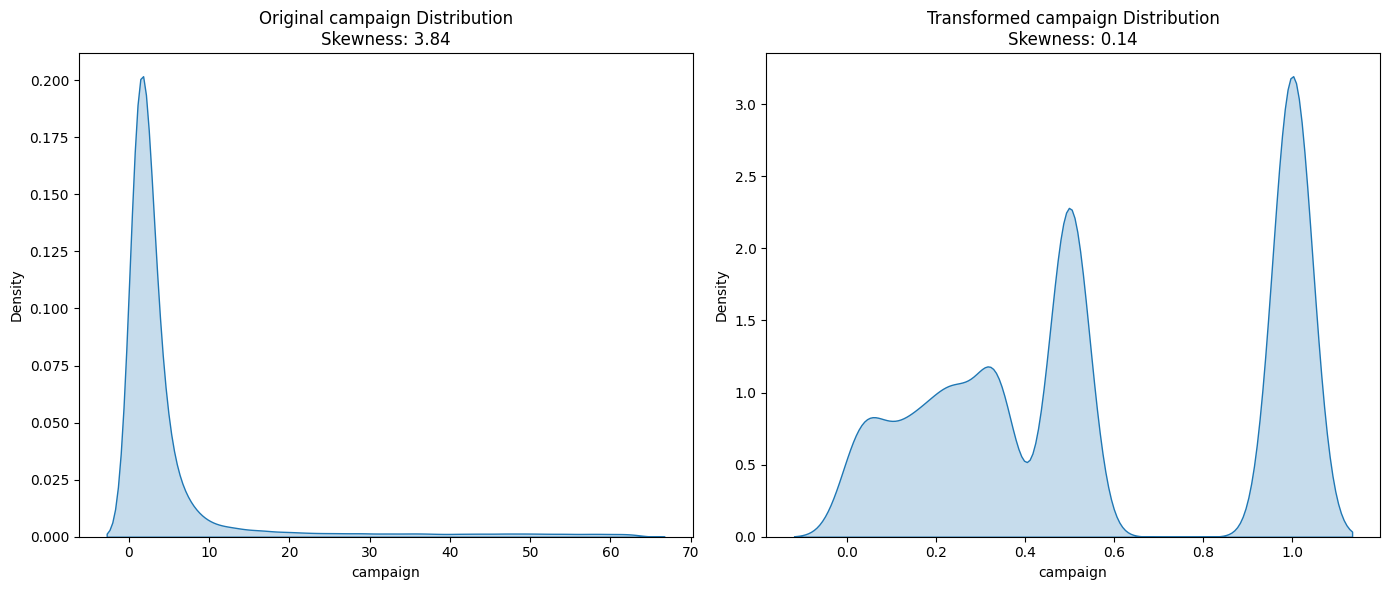

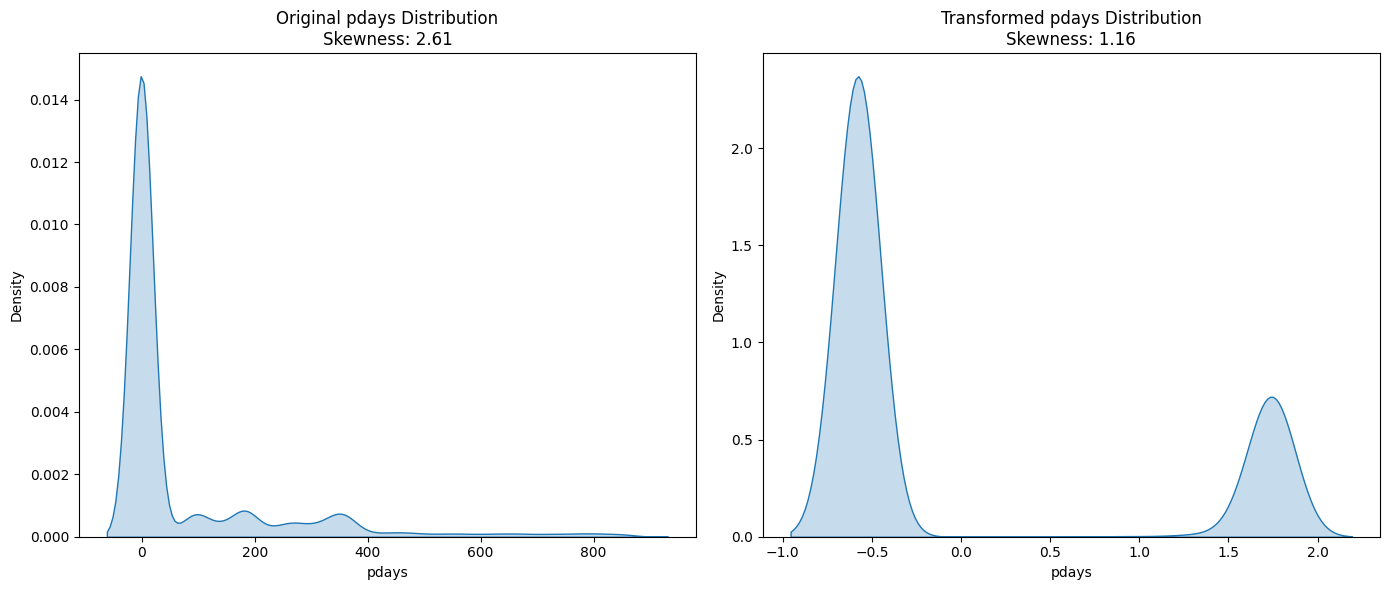

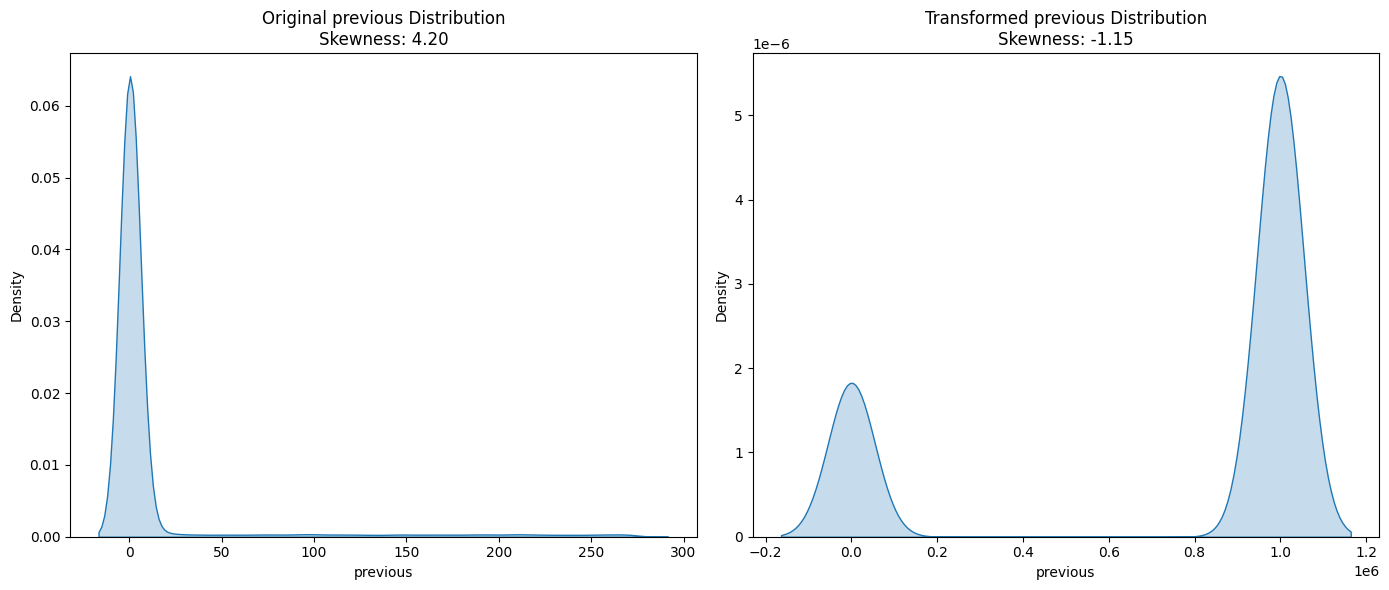

In [156]:
plot_original_vs_transformed(X_train, X_train_trf, columns_to_transform)

In [157]:
X_validation_trf, stats = apply_best_transformation(X_validation_trf, columns_to_transform)

# Display the stats to understand the skewness reduction
for col, info in stats.items():
    print(f"Column: {col}")
    print(f"  Best Transformation: {info['best_transformation']}")
    print(f"  Original Skew: {info['original_skew']}")
    print(f"  Transformed Skew: {info['transformed_skew']}")

Column: age
  Best Transformation: box-cox
  Original Skew: 1.1557691626927504
  Transformed Skew: 0.005267348820537485
Column: balance
  Best Transformation: yeo-johnson
  Original Skew: 4.058756201445879
  Transformed Skew: -1.6453332069600979
Column: duration
  Best Transformation: yeo-johnson
  Original Skew: 3.7019619666513743
  Transformed Skew: -0.021233913314094053
Column: campaign
  Best Transformation: reciprocal
  Original Skew: 3.8188272754432
  Transformed Skew: 0.1313071675961528
Column: pdays
  Best Transformation: yeo-johnson
  Original Skew: 2.6295417087208275
  Transformed Skew: 1.2097750701436427
Column: previous
  Best Transformation: reciprocal
  Original Skew: 4.236121562492945
  Transformed Skew: -1.2033920784989347


In [158]:
test_df_trf, stats = apply_best_transformation(test_df_trf, columns_to_transform)

# Display the stats to understand the skewness reduction
for col, info in stats.items():
    print(f"Column: {col}")
    print(f"  Best Transformation: {info['best_transformation']}")
    print(f"  Original Skew: {info['original_skew']}")
    print(f"  Transformed Skew: {info['transformed_skew']}")

Column: age
  Best Transformation: box-cox
  Original Skew: 1.0611280201838709
  Transformed Skew: 0.004247426984198418
Column: balance
  Best Transformation: yeo-johnson
  Original Skew: 4.091621564906037
  Transformed Skew: 0.34137334298703903
Column: duration
  Best Transformation: yeo-johnson
  Original Skew: 3.7175531546005782
  Transformed Skew: -0.021482022314263303
Column: campaign
  Best Transformation: reciprocal
  Original Skew: 3.815293008945991
  Transformed Skew: 0.12434453591343075
Column: pdays
  Best Transformation: yeo-johnson
  Original Skew: 2.6485559393760414
  Transformed Skew: 1.1680428065523878
Column: previous
  Best Transformation: reciprocal
  Original Skew: 4.135272501092962
  Transformed Skew: -1.1629018166878136


In [159]:
X_train = X_train_trf
X_validation = X_validation_trf
test_df = test_df_trf

## Feature Creation

In [160]:
# extract features from 'last contact date'
X_train['last_contact_year'] = X_train['last contact date'].dt.year
X_train['last_contact_month'] = X_train['last contact date'].dt.month
X_train['last_contact_day'] = X_train['last contact date'].dt.day
X_train['last_contact_weekday'] = X_train['last contact date'].dt.dayofweek
X_train['last_contact_is_weekend'] = np.where(X_train['last_contact_weekday'].isin([5, 6]), 1, 0)
X_train['last_contact_week_of_year'] = X_train['last contact date'].dt.isocalendar().week
X_train['last_contact_quarter'] = X_train['last contact date'].dt.quarter
X_train['last_contact_semester'] = np.where(X_train['last_contact_quarter'].isin([1, 2]), 1, 2)

# Drop the original 'last contact date' column
X_train = X_train.drop(columns=['last contact date'])

X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,previous,poutcome,last_contact_year,last_contact_month,last_contact_day,last_contact_weekday,last_contact_is_weekend,last_contact_week_of_year,last_contact_quarter,last_contact_semester
7362,0.185549,blue-collar,married,secondary,no,-0.277135,yes,no,Unknown,-0.296092,...,1000000.0,Unknown,2008,5,9,4,0,19,2,1
32857,-1.473049,blue-collar,married,primary,no,-0.244421,no,yes,cellular,0.019830,...,1000000.0,Unknown,2008,7,22,1,0,30,3,2
28964,0.101471,self-employed,married,secondary,no,-0.270773,yes,no,Unknown,-1.894292,...,1000000.0,Unknown,2009,5,15,4,0,20,2,1
6629,0.345893,housemaid,married,primary,no,-0.229255,no,no,cellular,-0.079370,...,1000000.0,Unknown,2010,7,7,2,0,27,3,2
631,-0.364583,blue-collar,single,secondary,no,0.242599,yes,no,cellular,0.759518,...,1000000.0,Unknown,2010,4,9,4,0,14,2,1


In [161]:
# extract features from 'last contact date'
X_validation['last_contact_year'] = X_validation['last contact date'].dt.year
X_validation['last_contact_month'] = X_validation['last contact date'].dt.month
X_validation['last_contact_day'] = X_validation['last contact date'].dt.day
X_validation['last_contact_weekday'] = X_validation['last contact date'].dt.dayofweek
X_validation['last_contact_is_weekend'] = np.where(X_validation['last_contact_weekday'].isin([5, 6]), 1, 0)
X_validation['last_contact_week_of_year'] = X_validation['last contact date'].dt.isocalendar().week
X_validation['last_contact_quarter'] = X_validation['last contact date'].dt.quarter
X_validation['last_contact_semester'] = np.where(X_validation['last_contact_quarter'].isin([1, 2]), 1, 2)

# Drop the original 'last contact date' column
X_validation = X_validation.drop(columns=['last contact date'])

X_validation.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,previous,poutcome,last_contact_year,last_contact_month,last_contact_day,last_contact_weekday,last_contact_is_weekend,last_contact_week_of_year,last_contact_quarter,last_contact_semester
19138,-1.200000,services,single,secondary,no,-0.240657,yes,no,Unknown,1.838665,...,1000000.0,Unknown,2008,5,20,1,0,21,2,1
21703,-0.370071,unemployed,divorced,secondary,no,-0.291939,yes,no,cellular,0.350989,...,1000000.0,Unknown,2009,7,8,2,0,28,3,2
32089,-0.474747,blue-collar,single,primary,no,-0.119507,yes,no,telephone,-2.584566,...,1000000.0,Unknown,2008,5,14,2,0,20,2,1
19762,-1.200000,blue-collar,married,secondary,no,0.019017,yes,no,Unknown,0.117042,...,1000000.0,Unknown,2008,5,27,1,0,22,2,1
13970,-1.643104,management,divorced,tertiary,yes,-1.131211,no,yes,cellular,-1.025590,...,0.5,failure,2010,1,29,4,0,4,1,1


In [162]:
# extract features from 'last contact date'
test_df['last_contact_year'] = test_df['last contact date'].dt.year
test_df['last_contact_month'] = test_df['last contact date'].dt.month
test_df['last_contact_day'] = test_df['last contact date'].dt.day
test_df['last_contact_weekday'] = test_df['last contact date'].dt.dayofweek
test_df['last_contact_is_weekend'] = np.where(test_df['last_contact_weekday'].isin([5, 6]), 1, 0)
test_df['last_contact_week_of_year'] = test_df['last contact date'].dt.isocalendar().week
test_df['last_contact_quarter'] = test_df['last contact date'].dt.quarter
test_df['last_contact_semester'] = np.where(test_df['last_contact_quarter'].isin([1, 2]), 1, 2)

# Drop the original 'last contact date' column
test_df = test_df.drop(columns=['last contact date'])

test_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,previous,poutcome,last_contact_year,last_contact_month,last_contact_day,last_contact_weekday,last_contact_is_weekend,last_contact_week_of_year,last_contact_quarter,last_contact_semester
0,-0.386283,management,single,tertiary,no,-0.289504,no,no,Unknown,-2.189906,...,1000000.0,Unknown,2009,11,21,5,1,47,4,2
1,-1.066423,unemployed,married,tertiary,no,-0.119807,no,no,cellular,-0.881060,...,1000000.0,Unknown,2010,2,4,3,0,5,1,1
2,-0.821765,blue-collar,single,secondary,no,-0.267294,yes,no,cellular,-0.789808,...,1000000.0,Unknown,2010,7,28,2,0,30,3,2
3,-0.191044,admin.,married,primary,no,-0.072072,no,no,Unknown,0.426189,...,1000000.0,Unknown,2010,6,9,2,0,23,2,1
4,1.294394,management,married,tertiary,no,-0.222534,no,no,cellular,0.917936,...,0.5,failure,2008,3,2,6,1,9,1,1


## Handling Outliers 

In [163]:
def find_outliers_zscore(df, column_name):
    # Calculate upper and lower limits via z-score
    upper_limit = df[column_name].mean() + 3*df[column_name].std()
    lower_limit = df[column_name].mean() - 3*df[column_name].std()
    
    # Print limits
    print(f"Upper limit for '{column_name}': {upper_limit}")
    print(f"Lower limit for '{column_name}': {lower_limit}")
    
    # Filter and return rows with outliers
    outliers_above = df[df[column_name] > upper_limit]
    outliers_below = df[df[column_name] < lower_limit]

    # Combine outliers
    outliers_df = pd.concat([outliers_above, outliers_below])
    
    # Calculate number and percentage of outliers
    total_outliers = outliers_df.shape[0]
    total_rows = df.shape[0]
    outlier_percentage = (total_outliers / total_rows) * 100
    
    print(f"\nTotal outliers: {total_outliers}")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    print(f"\nNumber of data above upper limit: {outliers_above.shape[0]}")
    print(f"\nNumber of data below lower limit: {outliers_below.shape[0]}")
    
    return upper_limit, lower_limit

In [164]:
def find_outliers_iqr(df, column_name):
    # Calculate the IQR
    percentile25 = df[column_name].quantile(0.25)
    percentile75 = df[column_name].quantile(0.75)
    iqr = percentile75 - percentile25
    
    # Calculate upper and lower limits
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    # Print limits
    print(f"Upper limit for '{column_name}': {upper_limit}")
    print(f"Lower limit for '{column_name}': {lower_limit}")
    
    # Filter and return rows with outliers
    outliers_above = df[df[column_name] > upper_limit]
    outliers_below = df[df[column_name] < lower_limit]

    # Combine outliers
    outliers_df = pd.concat([outliers_above, outliers_below])
    
    # Calculate number and percentage of outliers
    total_outliers = outliers_df.shape[0]
    total_rows = df.shape[0]
    outlier_percentage = (total_outliers / total_rows) * 100
    
    print(f"\nTotal outliers: {total_outliers}")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    print(f"\nNumber of data above upper limit: {outliers_above.shape[0]}")
    print(f"\nNumber of data below lower limit: {outliers_below.shape[0]}")
    
    return upper_limit, lower_limit

In [165]:
def find_outliers_percentile(df, column_name):
    # Calculate upper and lower limits
    upper_limit = df[column_name].quantile(0.99)
    lower_limit = df[column_name].quantile(0.01)
    
    # Print limits
    print(f"Upper limit for '{column_name}': {upper_limit}")
    print(f"Lower limit for '{column_name}': {lower_limit}")
    
    # Filter and return rows with outliers
    outliers_above = df[df[column_name] > upper_limit]
    outliers_below = df[df[column_name] < lower_limit]

    # Combine outliers
    outliers_df = pd.concat([outliers_above, outliers_below])
    
    # Calculate number and percentage of outliers
    total_outliers = outliers_df.shape[0]
    total_rows = df.shape[0]
    outlier_percentage = (total_outliers / total_rows) * 100
    
    print(f"\nTotal outliers: {total_outliers}")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    print(f"\nNumber of data above upper limit: {outliers_above.shape[0]}")
    print(f"\nNumber of data below lower limit: {outliers_below.shape[0]}")
    
    return upper_limit, lower_limit

In [166]:
def plot_outlier_capping(df, new_df, column_name):
    """
    Plots histograms and boxplots for a specified column before and after outlier capping.
    
    Parameters:
    df (DataFrame): The original DataFrame containing the data.
    new_df (DataFrame): The DataFrame after capping outliers.
    column_name (str): The name of the column to visualize.
    """
    
    # Create a figure with a 2x2 grid
    plt.figure(figsize=(16, 10))

    # Histogram for the specified column in original DataFrame
    plt.subplot(2, 2, 1)
    sns.histplot(df[column_name], kde=True, bins=30)
    plt.title(f'Distribution of {column_name} (Original Data)')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.grid(True)

    # Boxplot for the specified column in original DataFrame
    plt.subplot(2, 2, 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'Boxplot of {column_name} (Original Data)')
    plt.xlabel(column_name)
    plt.xlim(df[column_name].min() - 1, df[column_name].max() + 1)  # Add padding to x-axis
    plt.grid(True)

    # Histogram for the specified column in new DataFrame after capping
    plt.subplot(2, 2, 3)
    sns.histplot(new_df[column_name], kde=True, bins=30)
    plt.title(f'Distribution of {column_name} (After Outlier Capping)')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.grid(True)

    # Boxplot for the specified column in new DataFrame after capping
    plt.subplot(2, 2, 4)
    sns.boxplot(x=new_df[column_name])
    plt.title(f'Boxplot of {column_name} (After Outlier Capping)')
    plt.xlabel(column_name)
    plt.xlim(new_df[column_name].min() - 1, new_df[column_name].max() + 1)  # Add padding to x-axis
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [167]:
def cap_outliers(df, column_name, lower_limit, upper_limit):
    """
    Caps outliers in the specified column of the DataFrame based on the given lower and upper limits.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to cap outliers.
    lower_limit (float): The lower limit for capping outliers.
    upper_limit (float): The upper limit for capping outliers.
    
    Returns:
    DataFrame: DataFrame with outliers capped in the specified column.
    """
    
    # Count initial occurrences of values exactly at the upper and lower limits
    initial_above = (df[column_name] == upper_limit).sum()
    initial_below = (df[column_name] == lower_limit).sum()
    
    # Apply capping
    df[column_name] = df[column_name].apply(
        lambda x: upper_limit if x > upper_limit else (lower_limit if x < lower_limit else x)
    )
    
    # Count final occurrences of values exactly at the upper and lower limits
    final_above = (df[column_name] == upper_limit).sum()
    final_below = (df[column_name] == lower_limit).sum()
    
    # Calculate how many were newly capped
    capped_above = final_above - initial_above
    capped_below = final_below - initial_below
    
    print(f"Upper limit applied to {capped_above} new values in '{column_name}'.")
    print(f"Lower limit applied to {capped_below} new values in '{column_name}'.")
    
    return df

In [168]:
X_train_outlier = X_train.copy()
X_validation_outlier = X_validation.copy()
test_df_outlier = test_df.copy()

1. For normally distributed data (Skewness range: -0.5 to 0.5.), use Z-score capping. 
2. For moderately skewed data (Skewness range: ±0.5 to ±1), use IQR based capping.
3. For highly skewed or heavy-tailed data (Greater than ±1), use percentile-based capping.

### 1. **age** Column

In [169]:
X_train_outlier['age'].skew()

0.007458732391080521

In [170]:
# Finding Outliers
upper_limit_age_train, lower_limit_age_train = find_outliers_zscore(X_train_outlier, 'age')

Upper limit for 'age': 3.000047820577196
Lower limit for 'age': -3.0000478205771994

Total outliers: 35
Percentage of outliers: 0.11%

Number of data above upper limit: 0

Number of data below lower limit: 35


In [171]:
# capping outliers
X_train_outlier = cap_outliers(X_train_outlier, 'age', lower_limit_age_train, upper_limit_age_train)

Upper limit applied to 0 new values in 'age'.
Lower limit applied to 35 new values in 'age'.


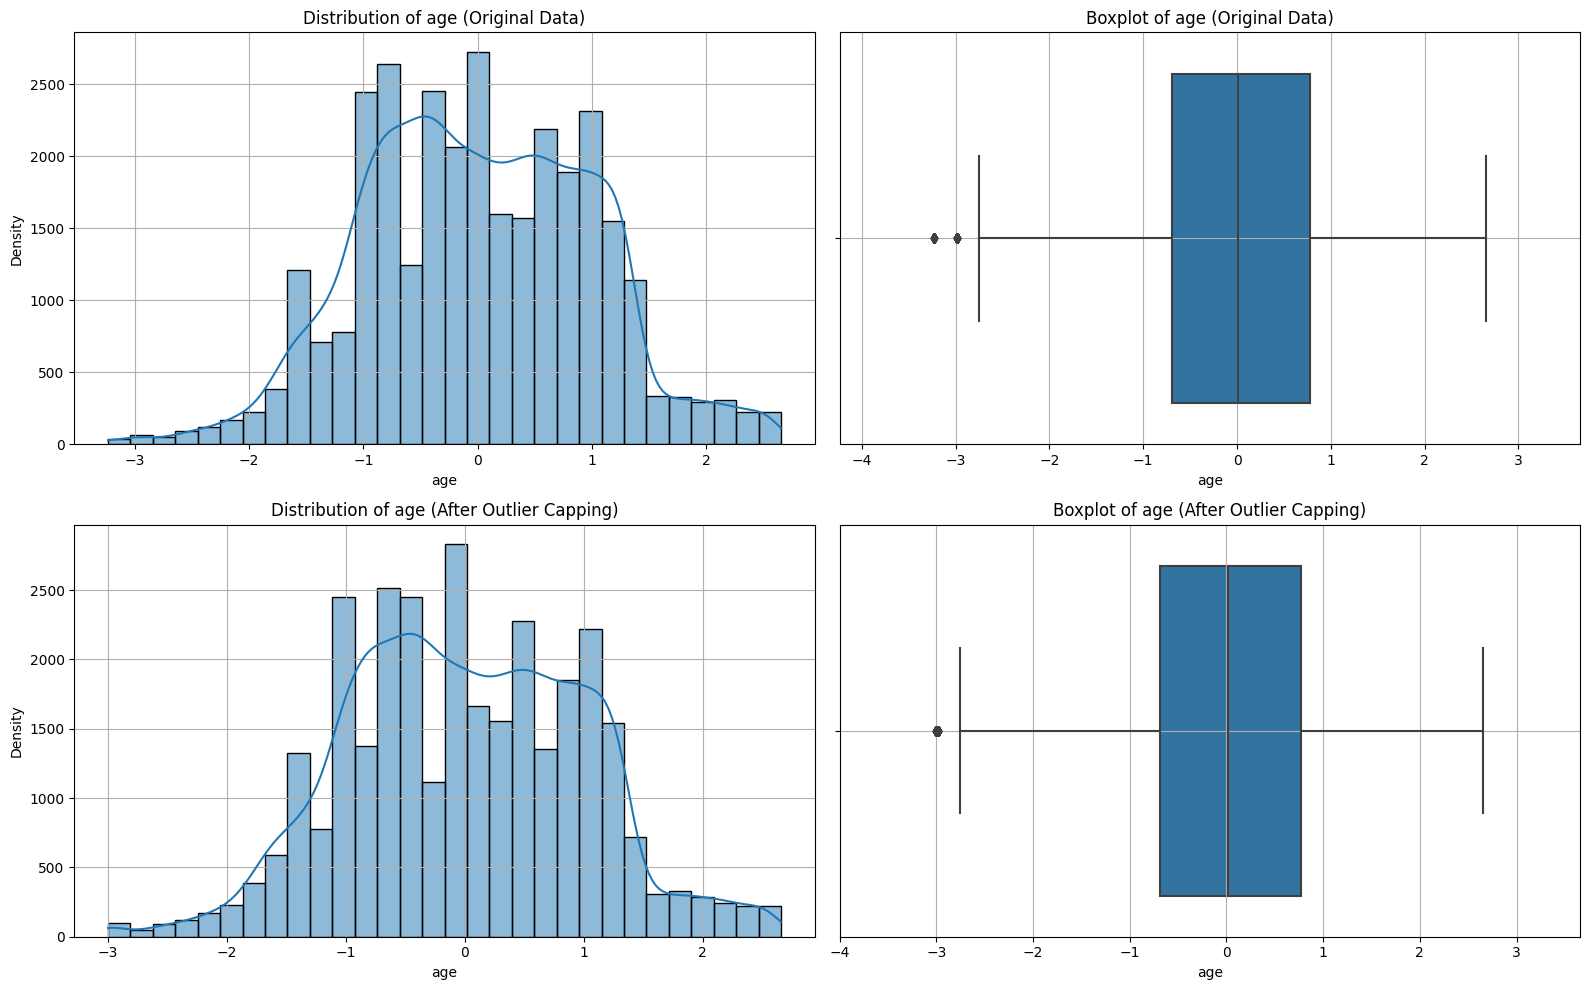

In [172]:
plot_outlier_capping(X_train, X_train_outlier, 'age')

In [173]:
# Finding Outliers in validation set
upper_limit_age_validation, lower_limit_age_validation = find_outliers_zscore(X_validation_outlier, 'age')

Upper limit for 'age': 3.0001912716377976
Lower limit for 'age': -3.0001912716377994

Total outliers: 26
Percentage of outliers: 0.33%

Number of data above upper limit: 0

Number of data below lower limit: 26


In [174]:
# capping outliers in validation set
X_validation_outlier = cap_outliers(X_validation_outlier, 'age', lower_limit_age_validation, upper_limit_age_validation)

Upper limit applied to 0 new values in 'age'.
Lower limit applied to 26 new values in 'age'.


In [175]:
# Finding Outliers in test set
upper_limit_age_test, lower_limit_age_test = find_outliers_zscore(test_df_outlier, 'age')

Upper limit for 'age': 3.000150011250938
Lower limit for 'age': -3.0001500112509363

Total outliers: 27
Percentage of outliers: 0.27%

Number of data above upper limit: 0

Number of data below lower limit: 27


In [176]:
# capping outliers in test set
test_df_outlier = cap_outliers(test_df_outlier, 'age', lower_limit_age_test, upper_limit_age_test)

Upper limit applied to 0 new values in 'age'.
Lower limit applied to 27 new values in 'age'.


### 2. **balance** Column

In [177]:
X_train_outlier['balance'].skew()

-2.446293821004067

In [178]:
# Finding Outliers
upper_limit_balance_train, lower_limit_balance_train = find_outliers_percentile(X_train_outlier, 'balance')

Upper limit for 'balance': 4.097190472853433
Lower limit for 'balance': -2.0617480175360705

Total outliers: 628
Percentage of outliers: 2.00%

Number of data above upper limit: 314

Number of data below lower limit: 314


In [179]:
# capping outliers
X_train_outlier = cap_outliers(X_train_outlier, 'balance', lower_limit_balance_train, upper_limit_balance_train)

Upper limit applied to 314 new values in 'balance'.
Lower limit applied to 314 new values in 'balance'.


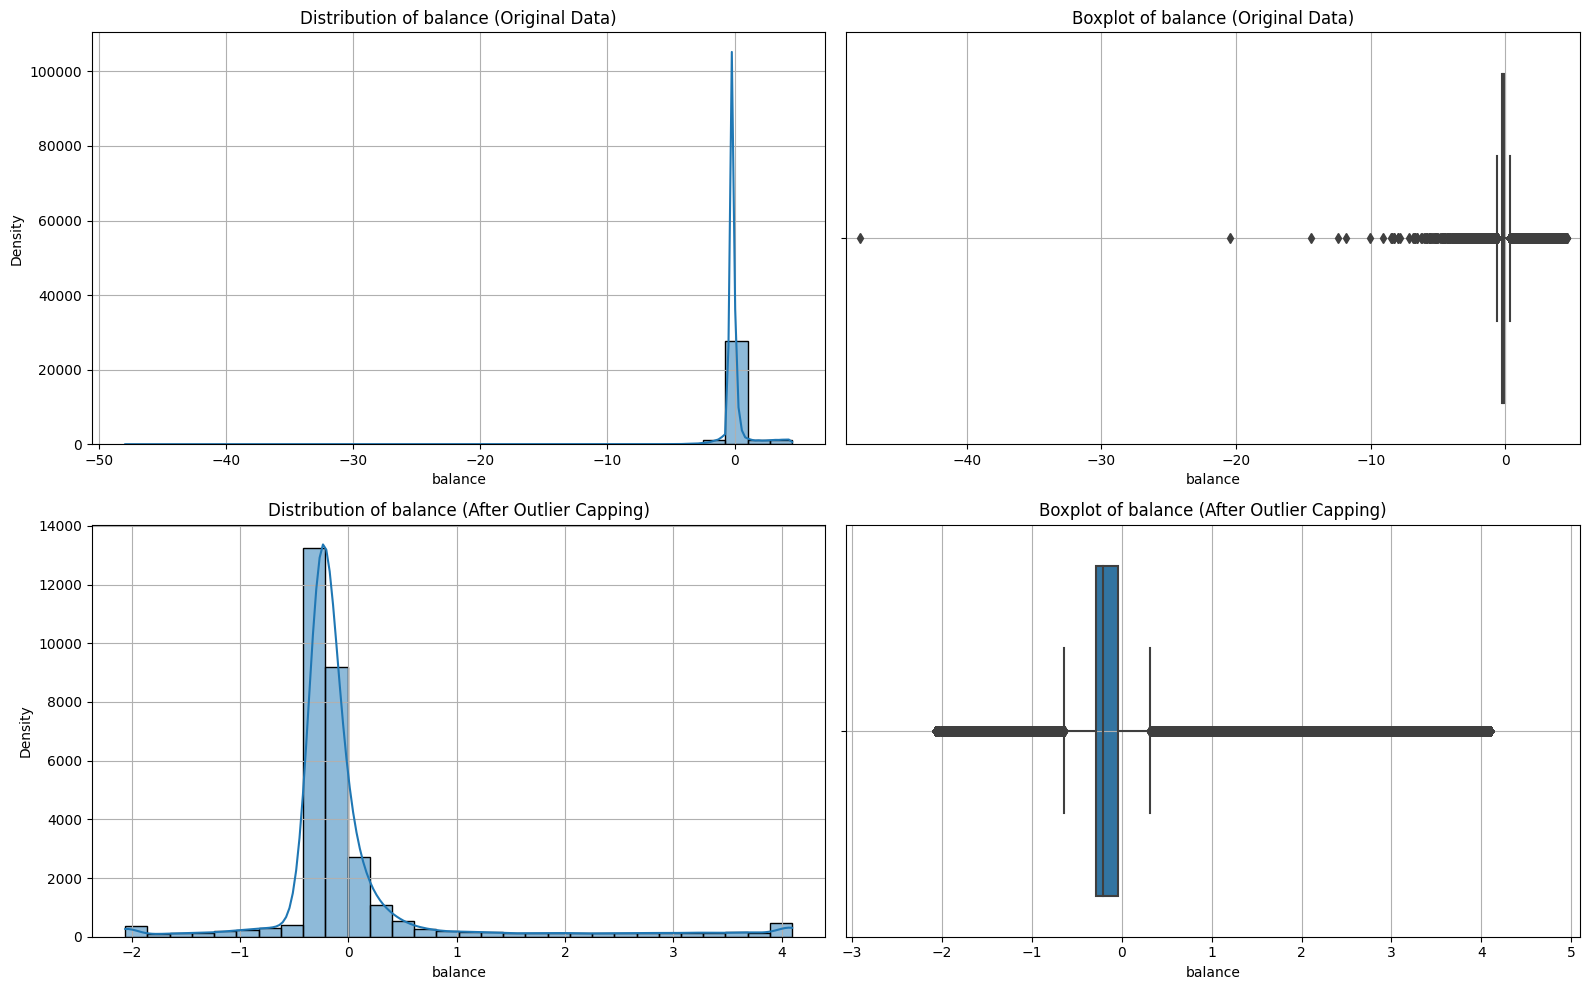

In [180]:
plot_outlier_capping(X_train, X_train_outlier, 'balance')

In [181]:
# Finding Outliers for validation
upper_limit_balance_validation, lower_limit_balance_validation = find_outliers_percentile(X_validation_outlier, 'balance')

Upper limit for 'balance': 4.090394986588237
Lower limit for 'balance': -1.8445282397769143

Total outliers: 158
Percentage of outliers: 2.01%

Number of data above upper limit: 79

Number of data below lower limit: 79


In [182]:
# capping outliers for validation
X_validation_outlier = cap_outliers(X_validation_outlier, 'balance', lower_limit_balance_validation, upper_limit_balance_validation)

Upper limit applied to 79 new values in 'balance'.
Lower limit applied to 79 new values in 'balance'.


In [183]:
# Finding Outliers for test
upper_limit_balance_test, lower_limit_balance_test = find_outliers_percentile(test_df_outlier, 'balance')

Upper limit for 'balance': 4.033816142166209
Lower limit for 'balance': -2.4863919208550325

Total outliers: 200
Percentage of outliers: 2.00%

Number of data above upper limit: 100

Number of data below lower limit: 100


In [184]:
# capping outliers for test
test_df_outlier = cap_outliers(test_df_outlier, 'balance', lower_limit_balance_test, upper_limit_balance_test)

Upper limit applied to 100 new values in 'balance'.
Lower limit applied to 100 new values in 'balance'.


### 3. **duration** Column

In [185]:
X_train_outlier['duration'].skew()

-0.020584674515778223

In [186]:
# Finding Outliers
upper_limit_duration_train, lower_limit_duration_train = find_outliers_zscore(X_train_outlier, 'duration')

Upper limit for 'duration': 3.0000478205771977
Lower limit for 'duration': -3.0000478205771977

Total outliers: 171
Percentage of outliers: 0.55%

Number of data above upper limit: 0

Number of data below lower limit: 171


In [187]:
# capping outliers
X_train_outlier = cap_outliers(X_train_outlier, 'duration', lower_limit_duration_train, upper_limit_duration_train)

Upper limit applied to 0 new values in 'duration'.
Lower limit applied to 171 new values in 'duration'.


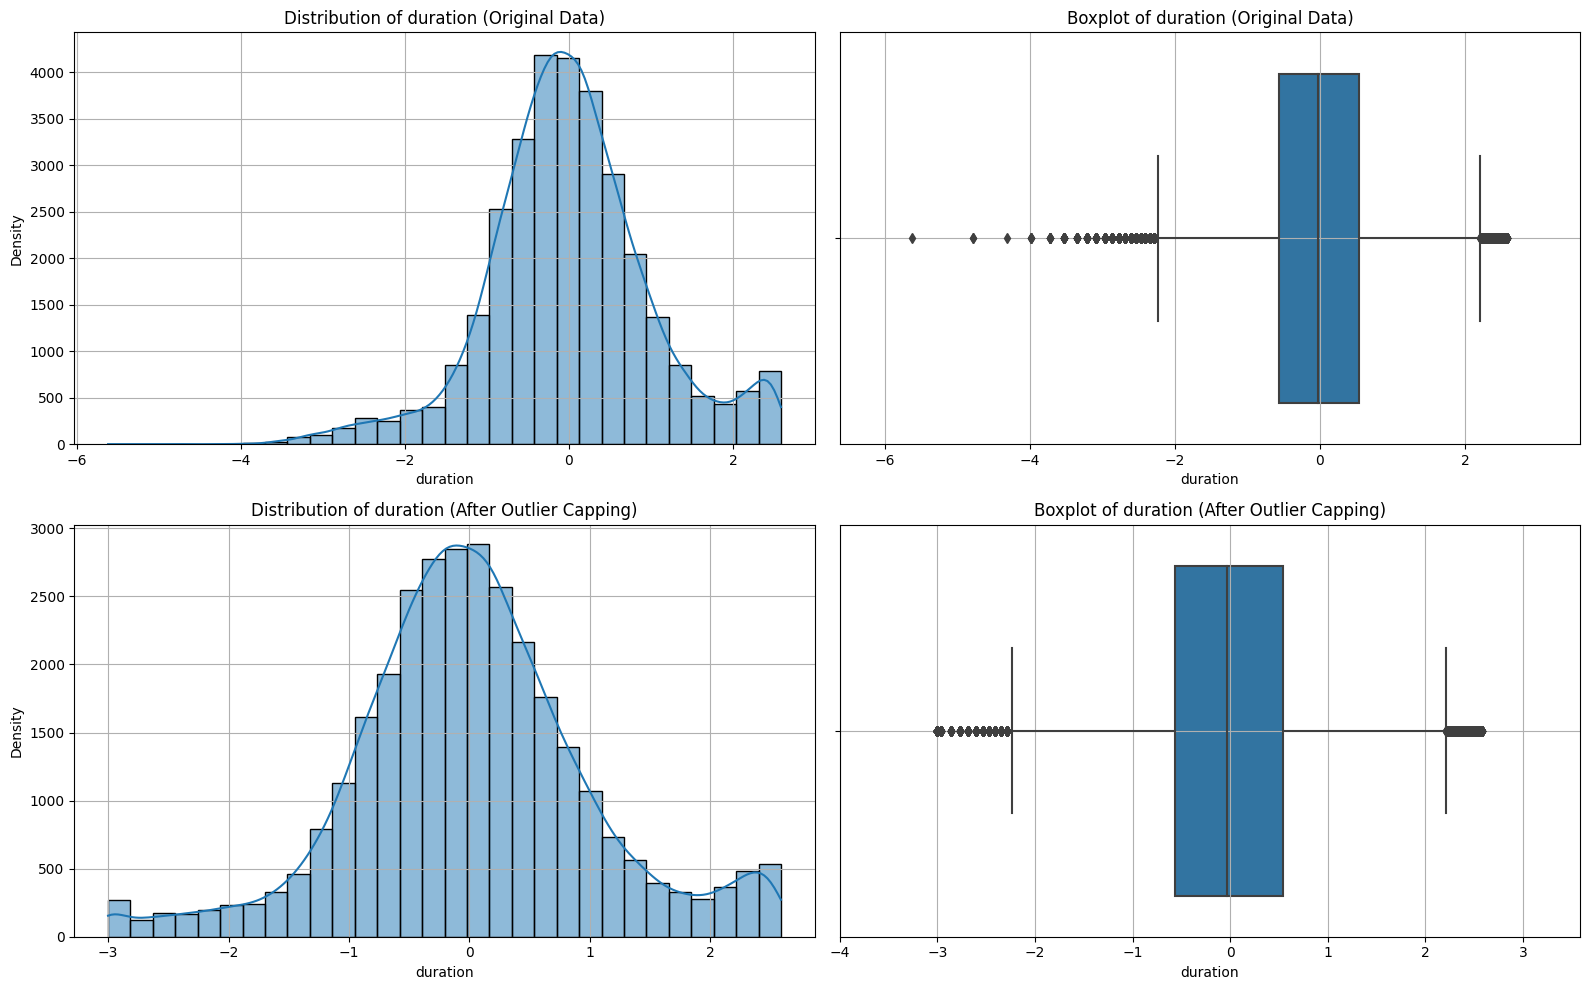

In [188]:
plot_outlier_capping(X_train, X_train_outlier, 'duration')

In [189]:
# Finding Outliers for validation
upper_limit_duration_validation, lower_limit_duration_validation = find_outliers_percentile(X_validation_outlier, 'duration')

Upper limit for 'duration': 2.4806212848266824
Lower limit for 'duration': -2.7462678838415515

Total outliers: 150
Percentage of outliers: 1.91%

Number of data above upper limit: 79

Number of data below lower limit: 71


In [190]:
# capping outliers for validation
X_validation_outlier = cap_outliers(X_validation_outlier, 'duration', lower_limit_duration_validation, upper_limit_duration_validation)

Upper limit applied to 79 new values in 'duration'.
Lower limit applied to 71 new values in 'duration'.


In [191]:
# Finding Outliers for test
upper_limit_duration_test, lower_limit_duration_test = find_outliers_percentile(test_df_outlier, 'duration')

Upper limit for 'duration': 2.487054937037144
Lower limit for 'duration': -2.690137445358058

Total outliers: 199
Percentage of outliers: 1.99%

Number of data above upper limit: 100

Number of data below lower limit: 99


In [192]:
# capping outliers for test
test_df_outlier = cap_outliers(test_df_outlier, 'duration', lower_limit_duration_test, upper_limit_duration_test)

Upper limit applied to 100 new values in 'duration'.
Lower limit applied to 99 new values in 'duration'.


### 4. **campaign** Column

In [193]:
X_train_outlier['campaign'].skew()

0.13824554135081504

In [194]:
# Finding Outliers
upper_limit_campaign_validation, lower_limit_campaign_validation = find_outliers_zscore(X_train_outlier, 'campaign')

Upper limit for 'campaign': 1.6230553980690154
Lower limit for 'campaign': -0.49811202234020435

Total outliers: 0
Percentage of outliers: 0.00%

Number of data above upper limit: 0

Number of data below lower limit: 0


**No Outlier**

In [195]:
# Finding Outliers for validation
upper_limit_campaign_validation, lower_limit_campaign_validation = find_outliers_percentile(X_validation_outlier, 'campaign')

Upper limit for 'campaign': 0.9999990000010001
Lower limit for 'campaign': 0.018518518175582997

Total outliers: 76
Percentage of outliers: 0.97%

Number of data above upper limit: 0

Number of data below lower limit: 76


In [196]:
# capping outliers for validation
X_validation_outlier = cap_outliers(X_validation_outlier, 'campaign', lower_limit_campaign_validation, upper_limit_campaign_validation)

Upper limit applied to 0 new values in 'campaign'.
Lower limit applied to 76 new values in 'campaign'.


In [197]:
# Finding Outliers for test
upper_limit_campaign_test, lower_limit_campaign_test = find_outliers_percentile(test_df_outlier, 'campaign')

Upper limit for 'campaign': 0.9999990000010001
Lower limit for 'campaign': 0.017857142538265314

Total outliers: 97
Percentage of outliers: 0.97%

Number of data above upper limit: 0

Number of data below lower limit: 97


In [198]:
# capping outliers for test
test_df_outlier = cap_outliers(test_df_outlier, 'campaign', lower_limit_campaign_test, upper_limit_campaign_test)

Upper limit applied to 0 new values in 'campaign'.
Lower limit applied to 97 new values in 'campaign'.


### 5. **pdays** Column

In [199]:
X_train_outlier['pdays'].skew()

1.1567921550112257

In [200]:
# Finding Outliers
upper_limit, lower_limit = find_outliers_percentile(X_train_outlier, 'pdays')

Upper limit for 'pdays': 1.809016006767518
Lower limit for 'pdays': -0.5778196715655723

Total outliers: 311
Percentage of outliers: 0.99%

Number of data above upper limit: 311

Number of data below lower limit: 0


In [201]:
# capping outliers
X_train_outlier = cap_outliers(X_train_outlier, 'pdays', lower_limit, upper_limit)

Upper limit applied to 311 new values in 'pdays'.
Lower limit applied to 0 new values in 'pdays'.


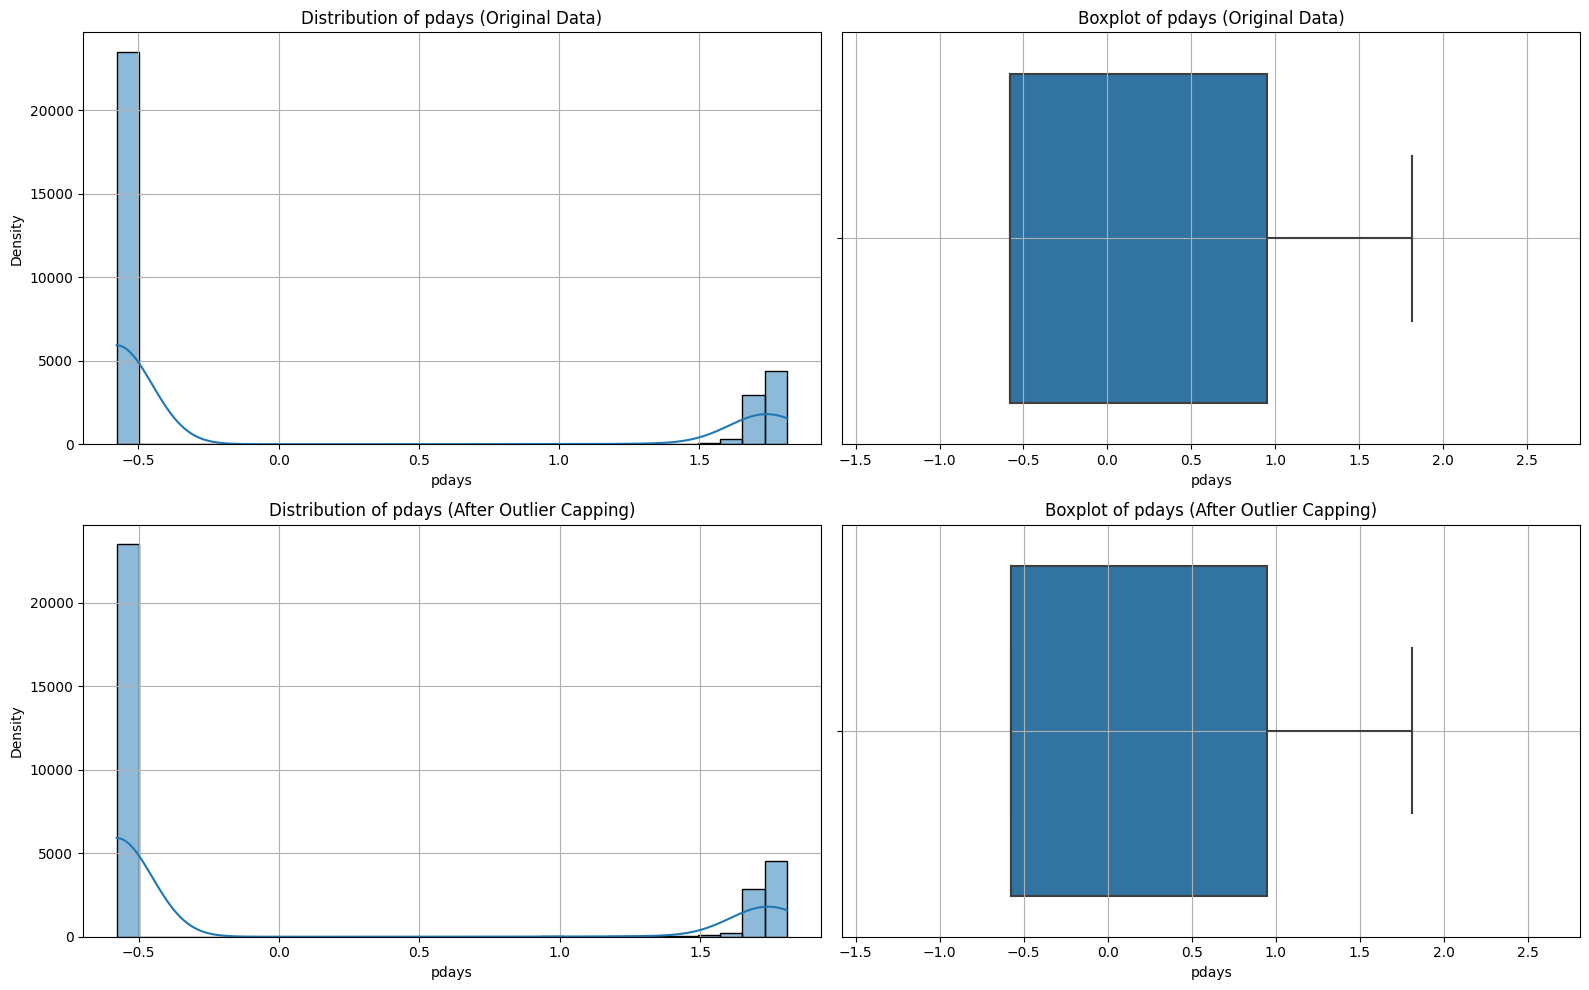

In [202]:
plot_outlier_capping(X_train, X_train_outlier, 'pdays')

In [203]:
# Finding Outliers for validation
upper_limit_pdays_validation, lower_limit_pdays_validation = find_outliers_percentile(X_validation_outlier, 'pdays')

Upper limit for 'pdays': 1.8422316041033113
Lower limit for 'pdays': -0.5649209692043334

Total outliers: 79
Percentage of outliers: 1.01%

Number of data above upper limit: 79

Number of data below lower limit: 0


In [204]:
# capping outliers for validation
X_validation_outlier = cap_outliers(X_validation_outlier, 'pdays', lower_limit_pdays_validation, upper_limit_pdays_validation)

Upper limit applied to 79 new values in 'pdays'.
Lower limit applied to 0 new values in 'pdays'.


In [205]:
# Finding Outliers for test
upper_limit_pdays_test, lower_limit_pdays_test = find_outliers_percentile(test_df_outlier, 'pdays')

Upper limit for 'pdays': 1.816697084260536
Lower limit for 'pdays': -0.5752877721475348

Total outliers: 100
Percentage of outliers: 1.00%

Number of data above upper limit: 100

Number of data below lower limit: 0


In [206]:
# capping outliers for test
test_df_outlier = cap_outliers(test_df_outlier, 'pdays', lower_limit_pdays_test, upper_limit_pdays_test)

Upper limit applied to 100 new values in 'pdays'.
Lower limit applied to 0 new values in 'pdays'.


### 6. **previous** Column

In [207]:
X_train_outlier['previous'].skew()

-1.152205491036563

In [208]:
# Finding Outliers
upper_limit, lower_limit = find_outliers_percentile(X_train_outlier, 'previous')

Upper limit for 'previous': 1000000.0
Lower limit for 'previous': 0.004115226320513472

Total outliers: 312
Percentage of outliers: 0.99%

Number of data above upper limit: 0

Number of data below lower limit: 312


In [209]:
# capping outliers
X_train_outlier = cap_outliers(X_train_outlier, 'previous', lower_limit, upper_limit)

Upper limit applied to 0 new values in 'previous'.
Lower limit applied to 312 new values in 'previous'.


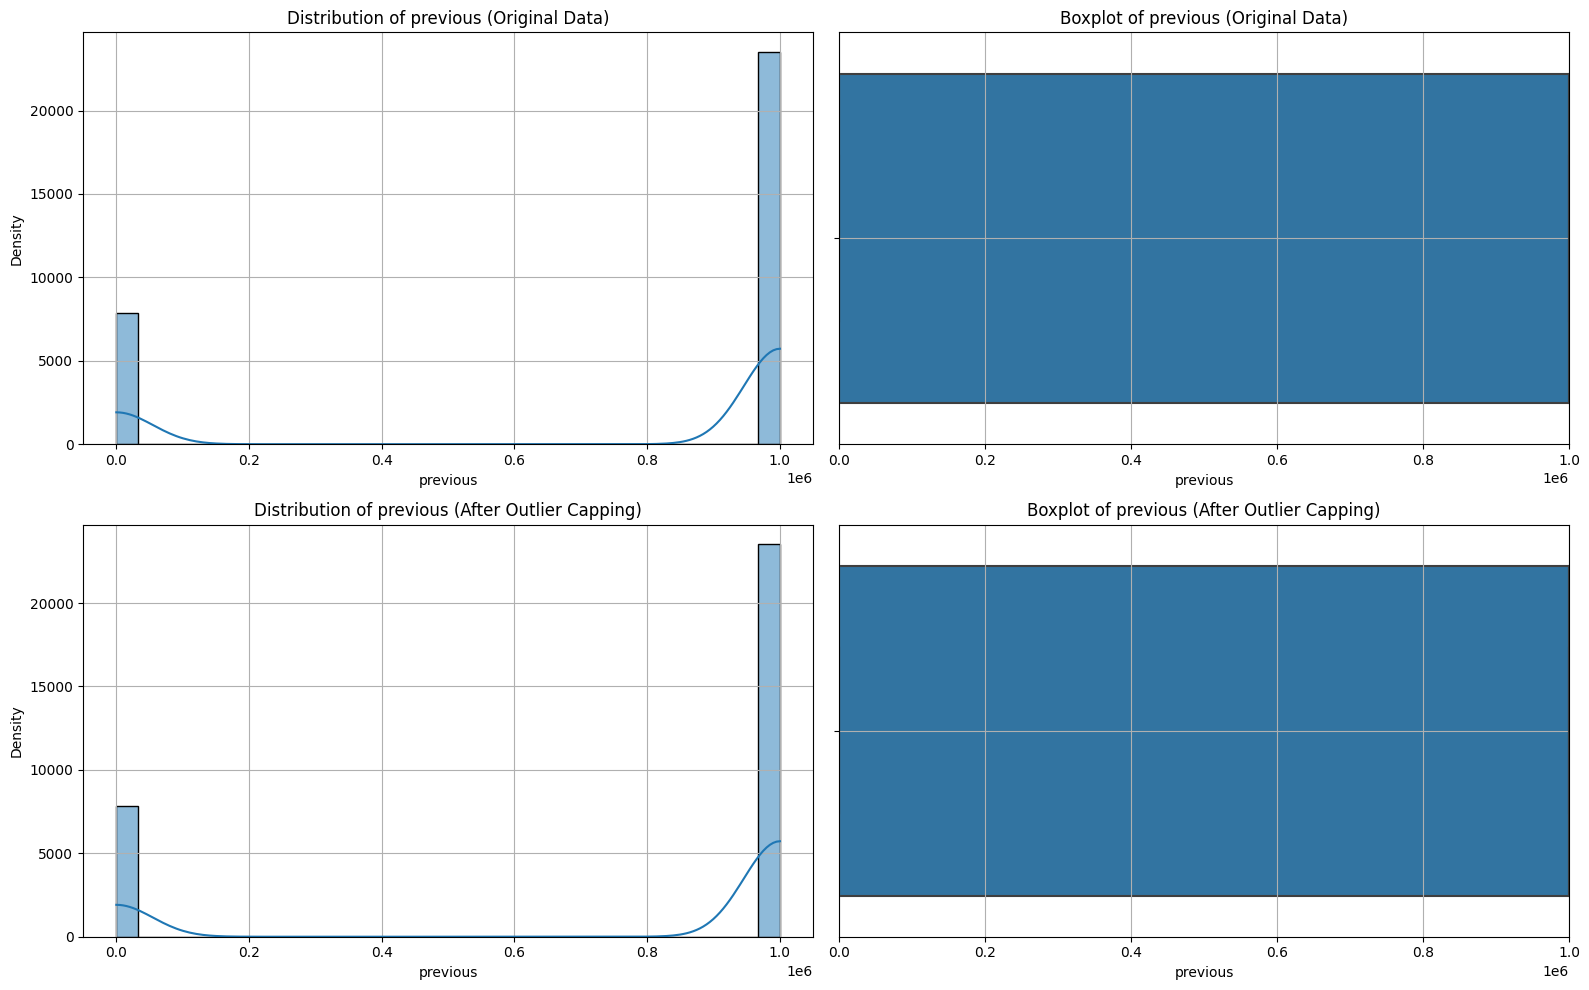

In [210]:
plot_outlier_capping(X_train, X_train_outlier, 'previous')

In [211]:
# Finding Outliers for validation
upper_limit_previous_validation, lower_limit_previous_validation = find_outliers_percentile(X_validation_outlier, 'previous')

Upper limit for 'previous': 1000000.0
Lower limit for 'previous': 0.0041493775761436615

Total outliers: 76
Percentage of outliers: 0.97%

Number of data above upper limit: 0

Number of data below lower limit: 76


In [212]:
# capping outliers for validation
X_validation_outlier = cap_outliers(X_validation_outlier, 'previous', lower_limit_previous_validation, upper_limit_previous_validation)

Upper limit applied to 0 new values in 'previous'.
Lower limit applied to 76 new values in 'previous'.


In [213]:
# Finding Outliers for test
upper_limit_previous_test, lower_limit_previous_test = find_outliers_percentile(test_df_outlier, 'previous')

Upper limit for 'previous': 1000000.0
Lower limit for 'previous': 0.004115057663697749

Total outliers: 100
Percentage of outliers: 1.00%

Number of data above upper limit: 0

Number of data below lower limit: 100


In [214]:
# capping outliers for test
test_df_outlier = cap_outliers(test_df_outlier, 'previous', lower_limit_previous_test, upper_limit_previous_test)

Upper limit applied to 0 new values in 'previous'.
Lower limit applied to 100 new values in 'previous'.


### Update

In [215]:
X_train = X_train_outlier
X_validation = X_validation_outlier
test_df = test_df_outlier

## Handling Categorical Features 

In [216]:
X_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'last_contact_year', 'last_contact_month',
       'last_contact_day', 'last_contact_weekday', 'last_contact_is_weekend',
       'last_contact_week_of_year', 'last_contact_quarter',
       'last_contact_semester'],
      dtype='object')

In [217]:
categorical_columns = X_train.select_dtypes(exclude=['number', 'datetime'])

In [218]:
categorical_columns

,job,marital,education,default,housing,loan,contact,poutcome
7362,blue-collar,married,secondary,no,yes,no,Unknown,Unknown
32857,blue-collar,married,primary,no,no,yes,cellular,Unknown
28964,self-employed,married,secondary,no,yes,no,Unknown,Unknown
6629,housemaid,married,primary,no,no,no,cellular,Unknown
631,blue-collar,single,secondary,no,yes,no,cellular,Unknown
...,...,...,...,...,...,...,...,...
20757,technician,married,tertiary,no,yes,yes,cellular,failure
32103,management,married,tertiary,no,no,no,telephone,Unknown
30403,technician,single,secondary,no,no,no,cellular,Unknown
21243,admin.,single,secondary,no,yes,no,Unknown,Unknown


In [219]:
categorical_columns['job'].unique()

array(['blue-collar', 'self-employed', 'housemaid', 'management',
       'admin.', 'technician', 'services', 'student', 'unemployed',
       'retired', 'entrepreneur'], dtype=object)

In [220]:
categorical_columns['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [221]:
categorical_columns['education'].unique()

array(['secondary', 'primary', 'tertiary'], dtype=object)

In [222]:
categorical_columns['default'].unique()

array(['no', 'yes'], dtype=object)

In [223]:
categorical_columns['housing'].unique()

array(['yes', 'no'], dtype=object)

In [224]:
categorical_columns['loan'].unique()

array(['no', 'yes'], dtype=object)

In [225]:
categorical_columns['contact'].unique()

array(['Unknown', 'cellular', 'telephone'], dtype=object)

In [226]:
categorical_columns['poutcome'].unique()

array(['Unknown', 'failure', 'success', 'other'], dtype=object)

1. **target** is a label column
2. **education** is ordered column

In [227]:
categorical_columns.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome'],
      dtype='object')

In [228]:
ordered_education = ['primary', 'secondary', 'tertiary']

## Transforming dataframe

In [229]:
ct = ColumnTransformer(
    [
        ("job", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]) , ['job']),

        ("marital", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]), ['marital']),

        ("education", Pipeline([
            ('ordered_encoder',OrdinalEncoder(categories=[ordered_education])),
        ]), ['education']),

        ("default", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]) , ['default']),

        ("housing", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]) , ['housing']),

        ("loan", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]) , ['loan']),

        ("contact", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]) , ['contact']),

        ("poutcome", Pipeline([
            ('encode',OneHotEncoder(drop='first')),
        ]) , ['poutcome']),

        ("date_features", Pipeline([
            ("scale", StandardScaler()),
        ]), ['last_contact_year', 'last_contact_month', 'last_contact_day', 'last_contact_weekday', 'last_contact_is_weekend', 'last_contact_week_of_year', 'last_contact_quarter', 'last_contact_semester']),
        
        ("best_numarical_transform", StandardScaler(), ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']),
    ],
    remainder='passthrough')

In [230]:
X_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'last_contact_year', 'last_contact_month',
       'last_contact_day', 'last_contact_weekday', 'last_contact_is_weekend',
       'last_contact_week_of_year', 'last_contact_quarter',
       'last_contact_semester'],
      dtype='object')

In [231]:
X_train = ct.fit_transform(X_train)
X_validation = ct.fit_transform(X_validation)
test_df = ct.fit_transform(test_df)

In [232]:
X_train = pd.DataFrame(X_train, columns=ct.get_feature_names_out())
X_validation = pd.DataFrame(X_validation, columns=ct.get_feature_names_out())
test_df = pd.DataFrame(test_df, columns=ct.get_feature_names_out())

In [233]:
# Clean up column names
X_train.columns = X_train.columns.str.replace(r'^(job|marital|education|default|housing|loan|contact|poutcome|date_features|best_numarical_transform|remainder)__', '', regex=True)
X_validation.columns = X_validation.columns.str.replace(r'^(job|marital|education|default|housing|loan|contact|poutcome|date_features|best_numarical_transform|remainder)__', '', regex=True)
test_df.columns = test_df.columns.str.replace(r'^(job|marital|education|default|housing|loan|contact|poutcome|date_features|best_numarical_transform|remainder)__', '', regex=True)

In [234]:
X_train

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,last_contact_is_weekend,last_contact_week_of_year,last_contact_quarter,last_contact_semester,age,balance,duration,campaign,pdays,previous
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.486482,-0.549425,-0.503057,-0.866339,0.185439,-0.328017,-0.299606,1.237623,-0.577821,0.577988
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.486482,0.403908,0.645073,1.154282,-1.474516,-0.291168,0.018179,-0.176713,-0.577821,0.577988
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.486482,-0.462758,-0.503057,-0.866339,0.101292,-0.320850,-1.907234,1.237623,-0.577821,0.577988
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.486482,0.143908,0.645073,1.154282,0.345914,-0.274085,-0.081606,-0.648159,-0.577821,0.577988
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.486482,-0.982758,-0.503057,-0.866339,-0.365143,0.257406,0.762232,-0.176713,-0.577821,0.577988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.055575,-1.676091,-1.651188,-0.866339,-0.365143,-0.332270,-0.795165,1.237623,1.655595,-1.730137
31364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.055575,1.877241,1.793204,1.154282,0.101292,0.611907,-1.328980,1.237623,-0.577821,0.577988
31365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.486482,-0.549425,-0.503057,-0.866339,-0.265126,-0.297234,-0.477964,1.237623,-0.577821,0.577988
31366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.486482,-0.549425,-0.503057,-0.866339,0.185439,-0.301770,-1.389729,-1.025315,-0.577821,0.577988


In [235]:
X_train.columns

Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education', 'default_yes', 'housing_yes', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'last_contact_year',
       'last_contact_month', 'last_contact_day', 'last_contact_weekday',
       'last_contact_is_weekend', 'last_contact_week_of_year',
       'last_contact_quarter', 'last_contact_semester', 'age', 'balance',
       'duration', 'campaign', 'pdays', 'previous'],
      dtype='object')

In [236]:
y_train

7362      no
32857     no
28964     no
6629      no
631       no
        ... 
20757     no
32103     no
30403     no
21243     no
2732     yes
Name: target, Length: 31368, dtype: object

In [237]:
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
y_validation = label_enc.fit_transform(y_validation)

In [238]:
y_train = pd.DataFrame(y_train, columns=['target'])

In [239]:
y_train

,target
0,0
1,0
2,0
3,0
4,0
...,...
31363,0
31364,0
31365,0
31366,0


## Feature Selection

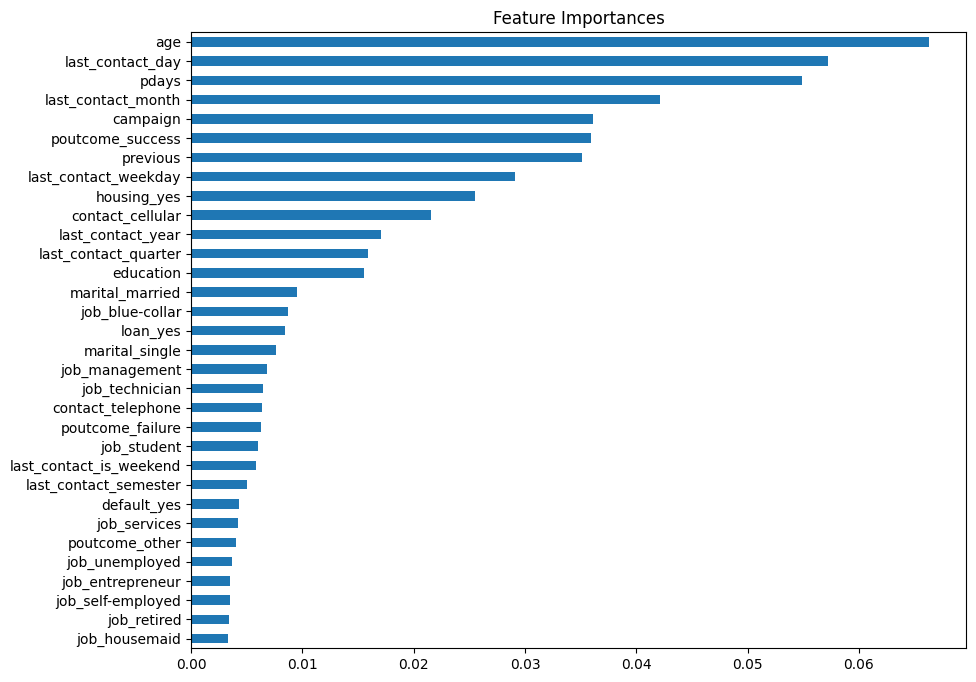

In [240]:
# Fit a Random Forest model
rf = RandomForestClassifier(random_state=0, class_weight='balanced')
rf.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_importances.head(32).plot(kind='barh')
plt.title("Feature Importances")
plt.show()

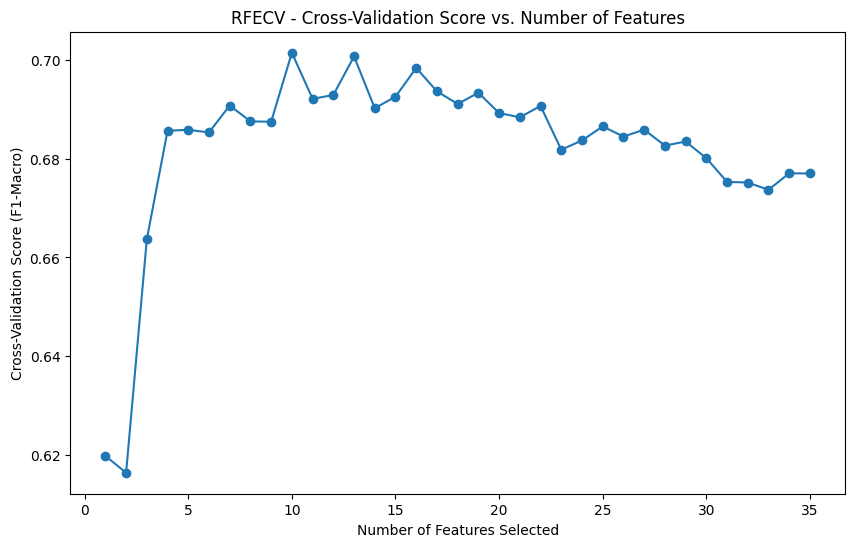

In [241]:
# Initialize the model and RFECV
model = RandomForestClassifier(random_state=0, class_weight='balanced')
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='f1_macro')
rfecv.fit(X_train, y_train)

# Access cross-validation scores for each feature count
mean_test_scores = rfecv.cv_results_['mean_test_score']

# Plot the cross-validation score against the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_test_scores) + 1), mean_test_scores, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (F1-Macro)")
plt.title("RFECV - Cross-Validation Score vs. Number of Features")
plt.show()

In [242]:
# Optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Get selected and rejected features
selected_features = X_train.columns[rfecv.support_]
rejected_features = X_train.columns[~rfecv.support_]

print("Selected Features:", list(selected_features))
print("Rejected Features:", list(rejected_features))

Optimal number of features: 10
Selected Features: ['poutcome_success', 'last_contact_month', 'last_contact_day', 'last_contact_week_of_year', 'age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
Rejected Features: ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education', 'default_yes', 'housing_yes', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_other', 'last_contact_year', 'last_contact_weekday', 'last_contact_is_weekend', 'last_contact_quarter', 'last_contact_semester']


In [243]:
# Update X_train with only the selected columns
X_train_selected = X_train[selected_features]
X_validation_selected = X_validation[selected_features]
test_df_selected = test_df[selected_features]

print("Updated X_train shape:", X_train_selected.shape)
print("Updated X_validation shape:", X_validation_selected.shape)
print("Updated test_df shape:", test_df_selected.shape)

Updated X_train shape: (31368, 10)
Updated X_validation shape: (7843, 10)
Updated test_df shape: (10000, 10)


In [244]:
X_train_features = X_train.copy()
X_validation_features = X_validation.copy()
test_df_features = test_df.copy()

X_train_features = X_train_features[['poutcome_success', 'poutcome_failure', 'poutcome_other', 'last_contact_month', 'last_contact_day', 'last_contact_week_of_year', 
'age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]
X_validation_features = X_validation_features[['poutcome_success', 'poutcome_failure', 'poutcome_other', 'last_contact_month', 'last_contact_day', 'last_contact_week_of_year', 
'age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]
test_df_features = test_df_features[['poutcome_success', 'poutcome_failure', 'poutcome_other', 'last_contact_month', 'last_contact_day', 'last_contact_week_of_year', 
'age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]

In [245]:
X_train_features

,poutcome_success,poutcome_failure,poutcome_other,last_contact_month,last_contact_day,last_contact_week_of_year,age,balance,duration,campaign,pdays,previous
0,0.0,0.0,0.0,-0.467752,-0.812664,-0.549425,0.185439,-0.328017,-0.299606,1.237623,-0.577821,0.577988
1,0.0,0.0,0.0,0.296896,0.744970,0.403908,-1.474516,-0.291168,0.018179,-0.176713,-0.577821,0.577988
2,0.0,0.0,0.0,-0.467752,-0.093756,-0.462758,0.101292,-0.320850,-1.907234,1.237623,-0.577821,0.577988
3,0.0,0.0,0.0,0.296896,-1.052300,0.143908,0.345914,-0.274085,-0.081606,-0.648159,-0.577821,0.577988
4,0.0,0.0,0.0,-0.850076,-0.812664,-0.982758,-0.365143,0.257406,0.762232,-0.176713,-0.577821,0.577988
...,...,...,...,...,...,...,...,...,...,...,...,...
31363,0.0,1.0,0.0,-1.614725,-0.692846,-1.676091,-0.365143,-0.332270,-0.795165,1.237623,1.655595,-1.730137
31364,0.0,0.0,0.0,1.826193,0.625152,1.877241,0.101292,0.611907,-1.328980,1.237623,-0.577821,0.577988
31365,0.0,0.0,0.0,-0.467752,-0.333392,-0.549425,-0.265126,-0.297234,-0.477964,1.237623,-0.577821,0.577988
31366,0.0,0.0,0.0,-0.467752,-0.213574,-0.549425,0.185439,-0.301770,-1.389729,-1.025315,-0.577821,0.577988


# Model Building

In [246]:
test_df.shape

(10000, 35)

In [247]:
def evaluate_model(model, X_val, y_val):
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Basic metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    auc_roc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None

    # Print metrics
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1-score: {f1:.5f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.5f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC curve
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
    
    return y_pred, y_pred_proba

## LogisticRegression

In [248]:
# Define parameter grid
logistic_clf = LogisticRegression(max_iter=1000, class_weight='balanced')
# Set up hyperparameter grid
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['saga']},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'saga']},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.25, 0.5, 0.75, 1]}
]

# Grid Search with Cross-Validation
logistic_grid_search = GridSearchCV(
    logistic_clf,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
logistic_grid_search.fit(X_train, y_train.values.ravel())  # Convert y_train to 1D array with .ravel()

print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)

Best parameters for Logistic Regression: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


In [249]:
# Retrieve the best model from GridSearchCV
best_logistic_model = logistic_grid_search.best_estimator_

Accuracy: 0.81308
Precision: 0.42329
Recall: 0.82035
F1-score: 0.71994
AUC-ROC: 0.88214

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      6713
           1       0.42      0.82      0.56      1130

    accuracy                           0.81      7843
   macro avg       0.69      0.82      0.72      7843
weighted avg       0.89      0.81      0.83      7843



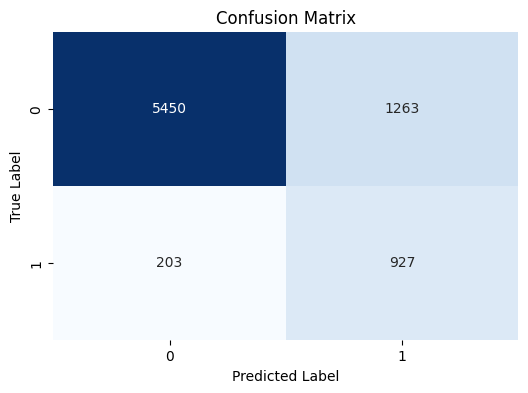

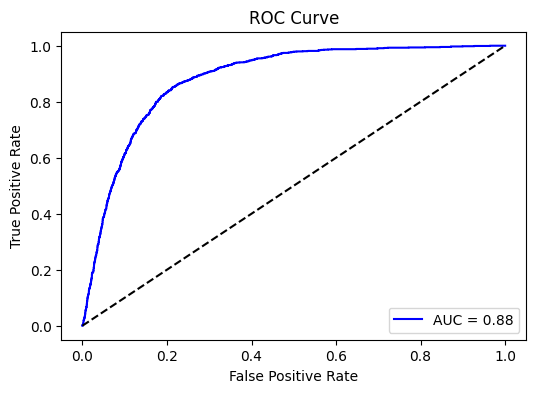

(array([1, 0, 0, ..., 0, 0, 1]),
 array([0.71255415, 0.40326766, 0.00376169, ..., 0.02610047, 0.08386191,
        0.66187319]))

In [250]:
evaluate_model(best_logistic_model, X_validation, y_validation)

In [251]:
lgr_pred = best_logistic_model.predict(test_df)
lgr_pred

array([0, 0, 0, ..., 0, 1, 0])

## Random Forest

In [252]:
# Define parameter grid X_train_balanced
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Grid Search with Cross-Validation
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=0, class_weight='balanced'),
    rf_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train.values.ravel())  # Convert y_train to 1D array with .ravel()

print("Best parameters for Random Forest:", rf_grid_search.best_params_)

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


In [253]:
# Retrieve the best model from GridSearchCV
best_rf_model = rf_grid_search.best_estimator_

Accuracy: 0.87020
Precision: 0.53500
Recall: 0.75752
F1-score: 0.77427
AUC-ROC: 0.91621

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      6713
           1       0.54      0.76      0.63      1130

    accuracy                           0.87      7843
   macro avg       0.75      0.82      0.77      7843
weighted avg       0.90      0.87      0.88      7843



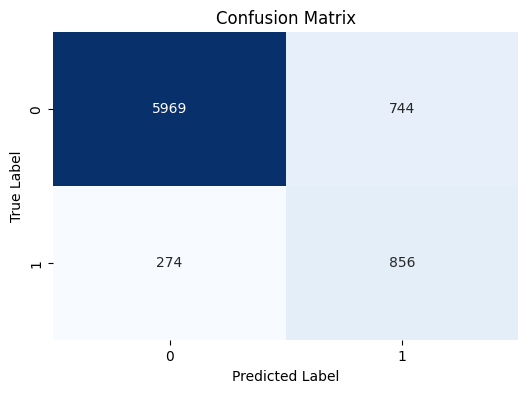

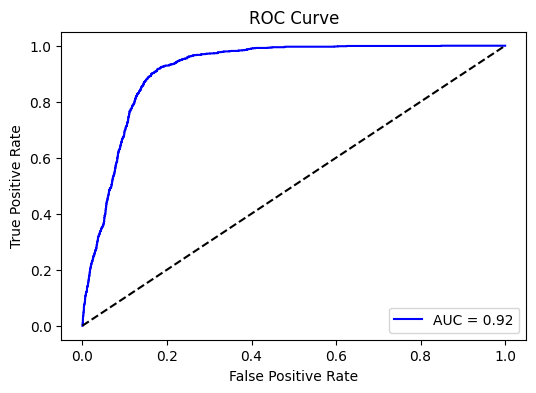

(array([1, 0, 0, ..., 0, 0, 1]),
 array([0.73469665, 0.06564813, 0.02792421, ..., 0.00816506, 0.08897056,
        0.64066783]))

In [254]:
evaluate_model(best_rf_model, X_validation, y_validation)

In [255]:
rf_pred = best_rf_model.predict(test_df)
rf_pred

array([0, 0, 0, ..., 1, 1, 0])

## XGBoost

In [256]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'max_depth': [3, 5, 7],                # Maximum tree depth for base learners
}

# Calculate scale_pos_weight as a float
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

# Instantiate an XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=0)

# Set up Grid Search with Cross-Validation
xgb_grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',    # Scoring with ROC AUC metric
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1             # Use all available cores
)

# Fit Grid Search
xgb_grid_search.fit(X_train_selected, y_train.values.ravel())  # Use .ravel() if y_train is a column vector

# Output the best parameters and score
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [257]:
# Retrieve the best model from GridSearchCV
best_xgb_model = xgb_grid_search.best_estimator_

Accuracy: 0.80569
Precision: 0.40812
Recall: 0.77434
F1-score: 0.70586
AUC-ROC: 0.87455

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      6713
           1       0.41      0.77      0.53      1130

    accuracy                           0.81      7843
   macro avg       0.68      0.79      0.71      7843
weighted avg       0.88      0.81      0.83      7843



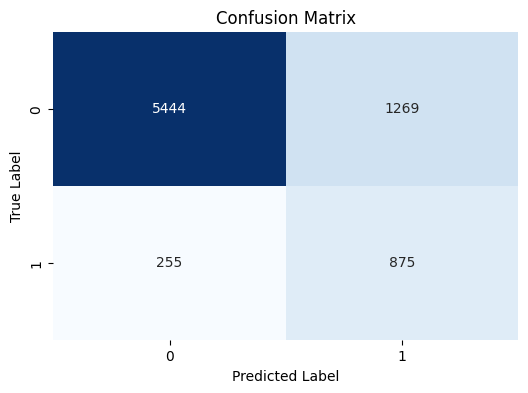

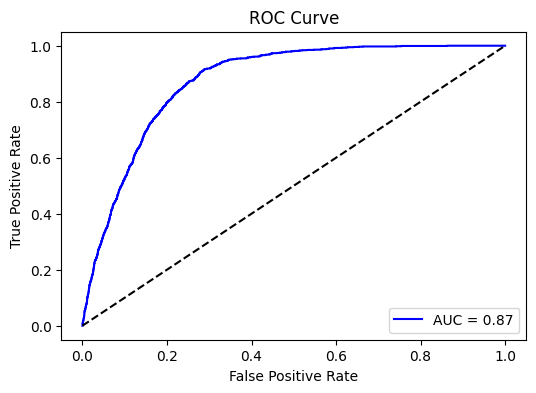

(array([1, 0, 0, ..., 0, 0, 1]),
 array([6.9271320e-01, 1.8037188e-01, 2.9889937e-04, ..., 2.0117829e-02,
        2.3957251e-02, 7.2009259e-01], dtype=float32))

In [258]:
evaluate_model(best_xgb_model, X_validation_selected, y_validation)

In [259]:
XGB_pred = best_xgb_model.predict(test_df_selected)
XGB_pred

array([0, 0, 0, ..., 0, 1, 0])

# output

In [260]:
# Replace 1 with "yes" and 0 with "no"
y_pred_mapped = ["yes" if y == 1 else "no" for y in rf_pred]

# Create the submission DataFrame
submission = pd.DataFrame({
    "id": test_df.index,
    "target": y_pred_mapped
})

# Save to CSV without an index column
submission.to_csv('submission.csv', index=False)

In [261]:
submission

,id,target
0,0,no
1,1,no
2,2,no
3,3,no
4,4,yes
...,...,...
9995,9995,no
9996,9996,yes
9997,9997,yes
9998,9998,yes


In [262]:
print(submission.columns)

Index(['id', 'target'], dtype='object')
